In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgbm
import category_encoders as ce
from sklearn.decomposition import PCA
from bayes_opt import BayesianOptimization

# for showing all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline 

In [2]:
# test=pd.read_csv("data/application_test.csv")
# train=pd.read_csv("data/application_train.csv")
# credit_card_balance=pd.read_csv("../input/credit_card_balance.csv")
# installments_payments=pd.read_csv("../input/installments_payments.csv")
bureau=pd.read_csv("data/bureau.csv")
bureau_balance=pd.read_csv("data/bureau_balance.csv")
# pos_cash=pd.read_csv("../input/POS_CASH_balance.csv")
# prev_applications=pd.read_csv("../input/previous_application.csv")
# y=train['TARGET']
# train.drop(columns=['TARGET'],inplace=True)

In [3]:
# print("Application train:",train.shape)
# print("Application test:",test.shape)
# print("Credit card balance:",credit_card_balance.shape)
# print("Installements Payements:",installments_payments.shape)
print("Bureau:",bureau.shape)
print("Bureau balance:",bureau_balance.shape)
# print("POS_cash Balance:",pos_cash.shape)
# print("Previous Applications:",prev_applications.shape)

Bureau: (1716428, 17)
Bureau balance: (27299925, 3)


## BUREAU BALANCE 

In [4]:
# bureau_balance=pd.get_dummies(bureau_balance,prefix='bureau_balance',columns=['STATUS'])
# bureau_balance.head()

In [5]:
# cols=bureau_balance.iloc[:,2:].columns
# bureau_balance_updated=pd.DataFrame()
# bureau_balance_updated['SK_ID_BUREAU']=pd.Series(sorted(list(set(bureau_balance['SK_ID_BUREAU']))))
# for i in cols:
#     bureau_balance_updated['count_'+i]=bureau_balance.groupby('SK_ID_BUREAU')[i].sum().values
# bureau_balance_updated['MAX_MONTHS_BALANCE']=bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].max().values
# bureau_balance_updated['MIN_MONTHS_BALANCE']=bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].min().values
# bureau_balance_updated['MEAN_MONTHS_BALANCE']=bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].mean().values
# bureau_balance_updated['Total_count']=bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].count().values
# bureau_balance_updated.head()

## BUREAU

In [6]:
# bureau=bureau.merge(right=bureau_balance_updated,how='left',on='SK_ID_BUREAU')
bureau.loc[(bureau['DAYS_ENDDATE_FACT'].isnull())& (bureau['CREDIT_ACTIVE']=='ACTIVE'),'DAYS_ENDDATE_FACT']=0
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [7]:
feat_cols=[col for col in bureau.columns if bureau[col].dtype=='object']
print(feat_cols)
# after printing feat_cols we can see that there are only three object type columns that is credit active,currency,type
bureau=pd.get_dummies(bureau,columns=feat_cols)
bureau.head()

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [8]:
credit_type_columns=['CREDIT_TYPE_Interbank credit','CREDIT_TYPE_Mobile operator loan','CREDIT_TYPE_Loan for purchase of shares (margin lending)'
            ,'CREDIT_TYPE_Loan for the purchase of equipment','CREDIT_TYPE_Real estate loan',
            'CREDIT_TYPE_Cash loan (non-earmarked)','CREDIT_TYPE_Loan for working capital replenishment',
            'CREDIT_TYPE_Unknown type of loan','CREDIT_TYPE_Another type of loan',
             'CREDIT_TYPE_Loan for business development']

credit_currency_columns=['CREDIT_CURRENCY_currency 2','CREDIT_CURRENCY_currency 3','CREDIT_CURRENCY_currency 4']

credit_active=['CREDIT_ACTIVE_Bad debt','CREDIT_ACTIVE_Sold']

bureau['CREDIT_TYPE_Misc']=bureau[credit_type_columns].sum(axis=1)
bureau['CREDIT_CURRENCY_Misc']=bureau[credit_currency_columns].sum(axis=1)
bureau['CREDIT_ACTIVE_MISC']=bureau[credit_active].sum(axis=1)
bureau.drop(columns=credit_type_columns,inplace=True)
bureau.drop(columns=credit_currency_columns,inplace=True)
bureau.drop(columns=credit_active,inplace=True)
print(bureau.shape)
bureau.head()

(1716428, 25)


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_CURRENCY_currency 1,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Misc,CREDIT_CURRENCY_Misc,CREDIT_ACTIVE_MISC
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN,0,1,1,0,1,0,0,0,0,0,0
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN,1,0,1,0,0,1,0,0,0,0,0
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,1,0,1,0,1,0,0,0,0,0,0
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN,1,0,1,0,0,1,0,0,0,0,0
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN,1,0,1,0,1,0,0,0,0,0,0


In [9]:
active=bureau.loc[bureau['CREDIT_ACTIVE_Active']==1].copy()
closed=bureau.loc[bureau['CREDIT_ACTIVE_Active']==0].copy()

active['LOAN_DURATION']=active['DAYS_CREDIT_ENDDATE']-active['DAYS_CREDIT']

active['AMT_CREDIT_TO_DEBT']=active['AMT_CREDIT_SUM']/(1+active['AMT_CREDIT_SUM_DEBT'])

active['TOTAL_DEBT']=active['AMT_CREDIT_SUM_DEBT']+active['AMT_CREDIT_SUM_OVERDUE']

active['AMT_CREDIT_TO_OVERDUE']=active['AMT_CREDIT_SUM']/(1+active['AMT_CREDIT_SUM_OVERDUE'])

active['TOTAL_DEBT_TO_LOAN_DURATION']=active['TOTAL_DEBT']/active['LOAN_DURATION']

active['AMT_CREDIT_TO_LIMIT']=active['AMT_CREDIT_SUM']/(1+active['AMT_CREDIT_SUM_LIMIT'])

# closed['LOAN_DURATION']=closed['DAYS_ENDDATE_FACT']-closed['DAYS_CREDIT']

# closed['AMT_CREDIT_TO_DEBT']=closed['AMT_CREDIT_SUM']/(1+closed['AMT_CREDIT_SUM_DEBT'])

# closed['TOTAL_DEBT']=closed['AMT_CREDIT_SUM_DEBT']+closed['AMT_CREDIT_SUM_OVERDUE']

# closed['AMT_CREDIT_TO_OVERDUE']=closed['AMT_CREDIT_SUM']/(1+closed['AMT_CREDIT_SUM_OVERDUE'])

# closed['TOTAL_DEBT_TO_LOAN_DURATION']=closed['TOTAL_DEBT']/closed['LOAN_DURATION']

# closed['AMT_CREDIT_TO_LIMIT']=closed['AMT_CREDIT_SUM']/(1+closed['AMT_CREDIT_SUM_LIMIT'])

bureau['LOAN_DURATION']=bureau['DAYS_CREDIT_ENDDATE']-bureau['DAYS_CREDIT']

bureau['AMT_CREDIT_TO_DEBT']=bureau['AMT_CREDIT_SUM']/(1+bureau['AMT_CREDIT_SUM_DEBT'])

bureau['TOTAL_DEBT']=bureau['AMT_CREDIT_SUM_DEBT']+bureau['AMT_CREDIT_SUM_OVERDUE']

bureau['AMT_CREDIT_TO_OVERDUE']=bureau['AMT_CREDIT_SUM']/(1+bureau['AMT_CREDIT_SUM_OVERDUE'])

bureau['TOTAL_DEBT_TO_LOAN_DURATION']=bureau['TOTAL_DEBT']/bureau['LOAN_DURATION']

bureau['AMT_CREDIT_TO_LIMIT']=bureau['AMT_CREDIT_SUM']/(1+bureau['AMT_CREDIT_SUM_LIMIT'])





print(active.shape,closed.shape,bureau.shape)

(630607, 31) (1085821, 25) (1716428, 31)


In [10]:
# ## some features i 
# bureau['LOAN_DURATION']=bureau['DAYS_CREDIT_ENDDATE']-bureau['DAYS_CREDIT']

# bureau['TOTAL_DEBT']=bureau['AMT_CREDIT_SUM_DEBT']+bureau['AMT_CREDIT_SUM_OVERDUE']+(bureau['AMT_CREDIT_SUM']/(1e-2+np.abs(bureau['DAYS_CREDIT'])))*bureau['DAYS_CREDIT_ENDDATE']*bureau['CREDIT_ACTIVE_Active']

# bureau['AMT_PER_DAY_BASIS']=bureau['AMT_CREDIT_SUM_DEBT']/(1e-2+bureau['DAYS_CREDIT_ENDDATE'])*bureau['CREDIT_ACTIVE_Active']

# bureau['AMT_CREDIT_TO_DEBT']=bureau['AMT_CREDIT_SUM']/(1+bureau['AMT_CREDIT_SUM_DEBT'])

# bureau['AMT_CREDIT_TO_OVERDUE']=bureau['AMT_CREDIT_SUM']/(1+bureau['AMT_CREDIT_SUM_OVERDUE'])

# bureau['AMT_CREDIT_T0_LIMIT']=bureau['AMT_CREDIT_SUM']/(1+bureau['AMT_CREDIT_SUM_LIMIT'])

# bureau['AMT_DEBT_TO_OVERDUE']=bureau['AMT_CREDIT_SUM_DEBT']/(1+bureau['AMT_CREDIT_SUM_OVERDUE'])

# # try after some time
# # bureau['ACTIVE_DAYS_CREDIT']=bureau['CREDIT_ACTIVE_Active']*bureau['DAYS_CREDIT']

# # bureau['AMT_DEBT_TO_ANNUITY']=bureau['AMT_CREDIT_SUM_DEBT']/(1+bureau['AMT_ANNUITY'])

# # bureau['AMT_CREDIT_TO_ANNUITY']=bureau['AMT_CREDIT_SUM']/(1+bureau['AMT_ANNUITY'])

# # bureau['AMT_CREDIT_LIMIT_TO_DEBT']=bureau['AMT_CREDIT_SUM_LIMIT']/(1+bureau['AMT_CREDIT_SUM_DEBT'])



# # normalizing credit_update
# max_values=bureau.groupby('SK_ID_CURR')['aDAYS_CREDIT_UPDATE'].min()
# bureau['VALUES']=bureau['SK_ID_CURR'].map(max_values)
# bureau['DAYS_CREDIT_UPDATE']=1-bureau['DAYS_CREDIT_UPDATE']/bureau['VALUES']
# bureau.drop(columns=['VALUES'],inplace=True)


# print(bureau.shape)
# bureau.head()

In [11]:
mean_bureau_cols=['DAYS_CREDIT','CREDIT_DAY_OVERDUE','DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','AMT_CREDIT_MAX_OVERDUE'
                 ,'AMT_CREDIT_MAX_OVERDUE','CNT_CREDIT_PROLONG','AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT',
                 'AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_OVERDUE','DAYS_CREDIT_UPDATE',
                 'AMT_ANNUITY','LOAN_DURATION','TOTAL_DEBT','AMT_CREDIT_TO_DEBT',
                 'AMT_CREDIT_TO_OVERDUE','TOTAL_DEBT_TO_LOAN_DURATION','AMT_CREDIT_TO_LIMIT']

add_bureau_cols=['CREDIT_ACTIVE_Active','CREDIT_ACTIVE_Closed','CREDIT_CURRENCY_currency 1','CREDIT_TYPE_Car loan',
                'CREDIT_TYPE_Consumer credit','CREDIT_TYPE_Credit card','CREDIT_TYPE_Microloan',
                'CREDIT_TYPE_Mortgage','CREDIT_TYPE_Misc','CREDIT_CURRENCY_Misc','CREDIT_ACTIVE_MISC']



In [12]:
## seperate for active and closed credits
active_updated=pd.DataFrame()

active_updated['SK_ID_CURR']=pd.Series(sorted(list(set(active['SK_ID_CURR'])))).values

for i in mean_bureau_cols:
    if 'TIME' in i or 'DAY' in i or 'CNT' in i or 'DURATION':
        active_updated['ACT_AVG_'+i]=active.groupby('SK_ID_CURR')[i].mean().values
        active_updated['ACT_MAX_'+i]=active.groupby('SK_ID_CURR')[i].max().values
        active_updated['ACT_MIN_'+i]=active.groupby('SK_ID_CURR')[i].min().values
    else:
        active_updated['ACT_AVG_'+i]=active.groupby('SK_ID_CURR')[i].mean().values
        active_updated['ACT_MAX_'+i]=active.groupby('SK_ID_CURR')[i].max().values
        active_updated['ACT_MIN_'+i]=active.groupby('SK_ID_CURR')[i].min().values
        active_updated['ACT_STD_'+i]=active.groupby('SK_ID_CURR')[i].std().values
        
for i in add_bureau_cols:
    active_updated['ACT_COUNT_'+i]=active.groupby('SK_ID_CURR')[i].sum().values

        
print(active_updated.shape)
active_updated.head()

(251815, 66)


,SK_ID_CURR,ACT_AVG_DAYS_CREDIT,ACT_MAX_DAYS_CREDIT,ACT_MIN_DAYS_CREDIT,ACT_AVG_CREDIT_DAY_OVERDUE,ACT_MAX_CREDIT_DAY_OVERDUE,ACT_MIN_CREDIT_DAY_OVERDUE,ACT_AVG_DAYS_CREDIT_ENDDATE,ACT_MAX_DAYS_CREDIT_ENDDATE,ACT_MIN_DAYS_CREDIT_ENDDATE,ACT_AVG_DAYS_ENDDATE_FACT,ACT_MAX_DAYS_ENDDATE_FACT,ACT_MIN_DAYS_ENDDATE_FACT,ACT_AVG_AMT_CREDIT_MAX_OVERDUE,ACT_MAX_AMT_CREDIT_MAX_OVERDUE,ACT_MIN_AMT_CREDIT_MAX_OVERDUE,ACT_AVG_CNT_CREDIT_PROLONG,ACT_MAX_CNT_CREDIT_PROLONG,ACT_MIN_CNT_CREDIT_PROLONG,ACT_AVG_AMT_CREDIT_SUM,ACT_MAX_AMT_CREDIT_SUM,ACT_MIN_AMT_CREDIT_SUM,ACT_AVG_AMT_CREDIT_SUM_DEBT,ACT_MAX_AMT_CREDIT_SUM_DEBT,ACT_MIN_AMT_CREDIT_SUM_DEBT,ACT_AVG_AMT_CREDIT_SUM_LIMIT,ACT_MAX_AMT_CREDIT_SUM_LIMIT,ACT_MIN_AMT_CREDIT_SUM_LIMIT,ACT_AVG_AMT_CREDIT_SUM_OVERDUE,ACT_MAX_AMT_CREDIT_SUM_OVERDUE,ACT_MIN_AMT_CREDIT_SUM_OVERDUE,ACT_AVG_DAYS_CREDIT_UPDATE,ACT_MAX_DAYS_CREDIT_UPDATE,ACT_MIN_DAYS_CREDIT_UPDATE,ACT_AVG_AMT_ANNUITY,ACT_MAX_AMT_ANNUITY,ACT_MIN_AMT_ANNUITY,ACT_AVG_LOAN_DURATION,ACT_MAX_LOAN_DURATION,ACT_MIN_LOAN_DURATION,ACT_AVG_TOTAL_DEBT,ACT_MAX_TOTAL_DEBT,ACT_MIN_TOTAL_DEBT,ACT_AVG_AMT_CREDIT_TO_DEBT,ACT_MAX_AMT_CREDIT_TO_DEBT,ACT_MIN_AMT_CREDIT_TO_DEBT,ACT_AVG_AMT_CREDIT_TO_OVERDUE,ACT_MAX_AMT_CREDIT_TO_OVERDUE,ACT_MIN_AMT_CREDIT_TO_OVERDUE,ACT_AVG_TOTAL_DEBT_TO_LOAN_DURATION,ACT_MAX_TOTAL_DEBT_TO_LOAN_DURATION,ACT_MIN_TOTAL_DEBT_TO_LOAN_DURATION,ACT_AVG_AMT_CREDIT_TO_LIMIT,ACT_MAX_AMT_CREDIT_TO_LIMIT,ACT_MIN_AMT_CREDIT_TO_LIMIT,ACT_COUNT_CREDIT_ACTIVE_Active,ACT_COUNT_CREDIT_ACTIVE_Closed,ACT_COUNT_CREDIT_CURRENCY_currency 1,ACT_COUNT_CREDIT_TYPE_Car loan,ACT_COUNT_CREDIT_TYPE_Consumer credit,ACT_COUNT_CREDIT_TYPE_Credit card,ACT_COUNT_CREDIT_TYPE_Microloan,ACT_COUNT_CREDIT_TYPE_Mortgage,ACT_COUNT_CREDIT_TYPE_Misc,ACT_COUNT_CREDIT_CURRENCY_Misc,ACT_COUNT_CREDIT_ACTIVE_MISC
0,100001,-309.333333,-49,-559,0.0,0,0,1030.333333,1778.0,411.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0,294675.0000,378000.0,168345.000,198895.50,373239.0,110281.5,0.0000,0.000,0.0,0.0,0.0,0.0,-10.666667,-6,-16,8272.50,10822.5,4630.5,1339.666667,1827.0,731.0,198895.50,373239.0,110281.5,1.841050,2.983909,1.012753,294675.0000,378000.0,168345.000,144.204144,204.290640,77.457906,357840.000000,378000.000000,337680.000000,3,0,3,0,3,0,0,0,0,0,0
1,100002,-572.500000,-103,-1042,0.0,0,0,780.000000,780.0,780.0,NaN,NaN,NaN,40.5,40.5,40.5,0.0,0,0,240994.2825,450000.0,31988.565,122890.50,245781.0,0.0,15994.2825,31988.565,0.0,0.0,0.0,0.0,-15.500000,-7,-24,0.00,0.0,0.0,1822.000000,1822.0,1822.0,122890.50,245781.0,0.0,15995.197945,31988.565000,1.830891,240994.2825,450000.0,31988.565,134.896268,134.896268,134.896268,225000.499984,450000.000000,0.999969,2,0,2,0,1,1,0,0,0,0,0
2,100003,-606.000000,-606,-606,0.0,0,0,1216.000000,1216.0,1216.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0,0,810000.0000,810000.0,810000.000,0.00,0.0,0.0,810000.0000,810000.000,810000.0,0.0,0.0,0.0,-43.000000,-43,-43,NaN,NaN,NaN,1822.000000,1822.0,1822.0,0.00,0.0,0.0,810000.000000,810000.000000,810000.000000,810000.0000,810000.0,810000.000,0.000000,0.000000,0.000000,0.999999,0.999999,0.999999,1,0,1,0,0,1,0,0,0,0,0
3,100005,-99.500000,-62,-137,0.0,0,0,723.000000,1324.0,122.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0,0,299313.0000,568800.0,29826.000,284204.25,543087.0,25321.5,0.0000,0.000,0.0,0.0,0.0,0.0,-21.000000,-11,-31,2130.75,4261.5,0.0,822.500000,1461.0,184.0,284204.25,543087.0,25321.5,1.112595,1.177846,1.047344,299313.0000,568800.0,29826.000,254.669820,371.722793,137.616848,299313.000000,568800.000000,29826.000000,2,0,2,0,2,0,0,0,0,0,0
4,100008,-78.000000,-78,-78,0.0,0,0,471.000000,471.0,471.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0,0,267606.0000,267606.0,267606.000,240057.00,240057.0,240057.0,0.0000,0.000,0.0,0.0,0.0,0.0,-16.000000,-16,-16,NaN,NaN,NaN,549.000000,549.0,549.0,240057.00,240057.0,240057.0,1.114756,1.114756,1.114756,267606.0000,267606.0,267606.000,437.262295,437.262295,437.262295,267606.000000,267606.000000,267606.000000,1,0,1,0,1,0,0,0,0,0,0


In [13]:
# closed_updated=pd.DataFrame()

# closed_updated['SK_ID_CURR']=pd.Series(sorted(list(set(closed['SK_ID_CURR'])))).values

# for i in mean_bureau_cols:
#     if 'TIME' in i or 'DAY' in i or 'CNT' in i or 'DURATION':
#         closed_updated['CLO_AVG_'+i]=closed.groupby('SK_ID_CURR')[i].mean().values
#         closed_updated['CLO_MAX_'+i]=closed.groupby('SK_ID_CURR')[i].max().values
#         closed_updated['CLO_MIN_'+i]=closed.groupby('SK_ID_CURR')[i].min().values
    
#     else:
#         closed_updated['CLO_AVG_'+i]=closed.groupby('SK_ID_CURR')[i].mean().values
#         closed_updated['CLO_MAX_'+i]=closed.groupby('SK_ID_CURR')[i].max().values
#         closed_updated['CLO_MIN_'+i]=closed.groupby('SK_ID_CURR')[i].min().values
#         closed_updated['CLO_STD_'+i]=closed.groupby('SK_ID_CURR')[i].std().values


# for i in add_bureau_cols:
#     closed_updated['CLO_COUNT_'+i]=closed.groupby('SK_ID_CURR')[i].sum().values

# print(closed_updated.shape)
# closed_updated.head()

In [14]:
bureau_updated=pd.DataFrame()
# as cols contain 0 and 1 so i will count them and for other variables i will average just like months_balance in bureau_balance
bureau_updated['SK_ID_CURR']=pd.Series(sorted(list(set(bureau['SK_ID_CURR'])))).values

for i in mean_bureau_cols:
    if 'TIME' in i or 'DAY' in i or 'CNT' in i or 'DURATION':
        bureau_updated['AVG_'+i]=bureau.groupby('SK_ID_CURR')[i].mean().values
        bureau_updated['MAX_'+i]=bureau.groupby('SK_ID_CURR')[i].max().values
        bureau_updated['MIN_'+i]=bureau.groupby('SK_ID_CURR')[i].min().values
    else:
        bureau_updated['AVG_'+i]=bureau.groupby('SK_ID_CURR')[i].mean().values
        bureau_updated['MAX_'+i]=bureau.groupby('SK_ID_CURR')[i].max().values
        bureau_updated['MIN_'+i]=bureau.groupby('SK_ID_CURR')[i].min().values
        bureau_updated['STD_'+i]=bureau.groupby('SK_ID_CURR')[i].std().values
for i in add_bureau_cols:
    bureau_updated['COUNT_'+i]=bureau.groupby('SK_ID_CURR')[i].sum().values
    
bureau_updated['BUR_COUNT']=bureau.groupby('SK_ID_CURR')['SK_ID_CURR'].count().values

# deleting all other files
del bureau

print(bureau_updated.shape)
bureau_updated.head()

(305811, 67)


,SK_ID_CURR,AVG_DAYS_CREDIT,MAX_DAYS_CREDIT,MIN_DAYS_CREDIT,AVG_CREDIT_DAY_OVERDUE,MAX_CREDIT_DAY_OVERDUE,MIN_CREDIT_DAY_OVERDUE,AVG_DAYS_CREDIT_ENDDATE,MAX_DAYS_CREDIT_ENDDATE,MIN_DAYS_CREDIT_ENDDATE,AVG_DAYS_ENDDATE_FACT,MAX_DAYS_ENDDATE_FACT,MIN_DAYS_ENDDATE_FACT,AVG_AMT_CREDIT_MAX_OVERDUE,MAX_AMT_CREDIT_MAX_OVERDUE,MIN_AMT_CREDIT_MAX_OVERDUE,AVG_CNT_CREDIT_PROLONG,MAX_CNT_CREDIT_PROLONG,MIN_CNT_CREDIT_PROLONG,AVG_AMT_CREDIT_SUM,MAX_AMT_CREDIT_SUM,MIN_AMT_CREDIT_SUM,AVG_AMT_CREDIT_SUM_DEBT,MAX_AMT_CREDIT_SUM_DEBT,MIN_AMT_CREDIT_SUM_DEBT,AVG_AMT_CREDIT_SUM_LIMIT,MAX_AMT_CREDIT_SUM_LIMIT,MIN_AMT_CREDIT_SUM_LIMIT,AVG_AMT_CREDIT_SUM_OVERDUE,MAX_AMT_CREDIT_SUM_OVERDUE,MIN_AMT_CREDIT_SUM_OVERDUE,AVG_DAYS_CREDIT_UPDATE,MAX_DAYS_CREDIT_UPDATE,MIN_DAYS_CREDIT_UPDATE,AVG_AMT_ANNUITY,MAX_AMT_ANNUITY,MIN_AMT_ANNUITY,AVG_LOAN_DURATION,MAX_LOAN_DURATION,MIN_LOAN_DURATION,AVG_TOTAL_DEBT,MAX_TOTAL_DEBT,MIN_TOTAL_DEBT,AVG_AMT_CREDIT_TO_DEBT,MAX_AMT_CREDIT_TO_DEBT,MIN_AMT_CREDIT_TO_DEBT,AVG_AMT_CREDIT_TO_OVERDUE,MAX_AMT_CREDIT_TO_OVERDUE,MIN_AMT_CREDIT_TO_OVERDUE,AVG_TOTAL_DEBT_TO_LOAN_DURATION,MAX_TOTAL_DEBT_TO_LOAN_DURATION,MIN_TOTAL_DEBT_TO_LOAN_DURATION,AVG_AMT_CREDIT_TO_LIMIT,MAX_AMT_CREDIT_TO_LIMIT,MIN_AMT_CREDIT_TO_LIMIT,COUNT_CREDIT_ACTIVE_Active,COUNT_CREDIT_ACTIVE_Closed,COUNT_CREDIT_CURRENCY_currency 1,COUNT_CREDIT_TYPE_Car loan,COUNT_CREDIT_TYPE_Consumer credit,COUNT_CREDIT_TYPE_Credit card,COUNT_CREDIT_TYPE_Microloan,COUNT_CREDIT_TYPE_Mortgage,COUNT_CREDIT_TYPE_Misc,COUNT_CREDIT_CURRENCY_Misc,COUNT_CREDIT_ACTIVE_MISC,BUR_COUNT
0,100001,-735.000000,-49,-1572,0.0,0,0,82.428571,1778.0,-1329.0,-825.500000,-544.0,-1328.0,NaN,NaN,NaN,0.0,0,0,207623.571429,378000.0,85500.0,85240.928571,373239.0,0.0,0.00000,0.000,0.0,0.0,0.0,0.0,-93.142857,-6,-155,3545.357143,10822.5,0.0,817.428571,1827.0,243.0,85240.928571,373239.0,0.0,81335.074736,279720.0,1.012753,207623.571429,378000.0,85500.0,61.801776,204.290640,0.0,214170.000000,378000.0,85500.000000,3,4,7,0,7,0,0,0,0,0,0,7
1,100002,-874.000000,-103,-1437,0.0,0,0,-349.000000,780.0,-1072.0,-697.500000,-36.0,-1185.0,1681.029,5043.645,0.0,0.0,0,0,108131.945625,450000.0,0.0,49156.200000,245781.0,0.0,7997.14125,31988.565,0.0,0.0,0.0,0.0,-499.875000,-7,-1185,0.000000,0.0,0.0,719.833333,1822.0,87.0,49156.200000,245781.0,0.0,57545.079178,135000.0,0.000000,108131.945625,450000.0,0.0,44.965423,134.896268,0.0,176433.999992,450000.0,0.999969,2,6,8,0,4,4,0,0,0,0,0,8
2,100003,-1400.750000,-606,-2586,0.0,0,0,-544.500000,1216.0,-2434.0,-1097.333333,-540.0,-2131.0,0.000,0.000,0.0,0.0,0,0,254350.125000,810000.0,22248.0,0.000000,0.0,0.0,202500.00000,810000.000,0.0,0.0,0.0,0.0,-816.000000,-43,-2131,NaN,NaN,NaN,856.250000,1822.0,152.0,0.000000,0.0,0.0,254350.125000,810000.0,22248.000000,254350.125000,810000.0,22248.0,0.000000,0.000000,0.0,51850.375000,112500.0,0.999999,1,3,4,0,2,2,0,0,0,0,0,4
3,100004,-867.000000,-408,-1326,0.0,0,0,-488.500000,-382.0,-595.0,-532.500000,-382.0,-683.0,0.000,0.000,0.0,0.0,0,0,94518.900000,94537.8,94500.0,0.000000,0.0,0.0,0.00000,0.000,0.0,0.0,0.0,0.0,-532.000000,-382,-682,NaN,NaN,NaN,378.500000,731.0,26.0,0.000000,0.0,0.0,94518.900000,94537.8,94500.000000,94518.900000,94537.8,94500.0,0.000000,0.000000,0.0,94518.900000,94537.8,94500.000000,0,2,2,0,2,0,0,0,0,0,0,2
4,100005,-190.666667,-62,-373,0.0,0,0,439.333333,1324.0,-128.0,-123.000000,-123.0,-123.0,0.000,0.000,0.0,0.0,0,0,219042.000000,568800.0,29826.0,189469.500000,543087.0,0.0,0.00000,0.000,0.0,0.0,0.0,0.0,-54.333333,-11,-121,1420.500000,4261.5,0.0,630.000000,1461.0,184.0,189469.500000,543087.0,0.0,19500.741730,58500.0,1.047344,219042.000000,568800.0,29826.0,169.779880,371.722793,0.0,219042.000000,568800.0,29826.000000,2,1,3,0,2,1,0,0,0,0,0,3


In [15]:
# bureau_updated=bureau_updated.merge(right=active_updated,on='SK_ID_CURR',how='left')
# print(bureau_updated.shape)
# bureau_updated.head()

# active_updated=active_updated.merge(right=closed_updated,on='SK_ID_CURR',how='outer')
bureau_updated=bureau_updated.merge(right=active_updated,on='SK_ID_CURR',how='left')
print(bureau_updated.shape)
bureau_updated.head()

(305811, 132)


,SK_ID_CURR,AVG_DAYS_CREDIT,MAX_DAYS_CREDIT,MIN_DAYS_CREDIT,AVG_CREDIT_DAY_OVERDUE,MAX_CREDIT_DAY_OVERDUE,MIN_CREDIT_DAY_OVERDUE,AVG_DAYS_CREDIT_ENDDATE,MAX_DAYS_CREDIT_ENDDATE,MIN_DAYS_CREDIT_ENDDATE,AVG_DAYS_ENDDATE_FACT,MAX_DAYS_ENDDATE_FACT,MIN_DAYS_ENDDATE_FACT,AVG_AMT_CREDIT_MAX_OVERDUE,MAX_AMT_CREDIT_MAX_OVERDUE,MIN_AMT_CREDIT_MAX_OVERDUE,AVG_CNT_CREDIT_PROLONG,MAX_CNT_CREDIT_PROLONG,MIN_CNT_CREDIT_PROLONG,AVG_AMT_CREDIT_SUM,MAX_AMT_CREDIT_SUM,MIN_AMT_CREDIT_SUM,AVG_AMT_CREDIT_SUM_DEBT,MAX_AMT_CREDIT_SUM_DEBT,MIN_AMT_CREDIT_SUM_DEBT,AVG_AMT_CREDIT_SUM_LIMIT,MAX_AMT_CREDIT_SUM_LIMIT,MIN_AMT_CREDIT_SUM_LIMIT,AVG_AMT_CREDIT_SUM_OVERDUE,MAX_AMT_CREDIT_SUM_OVERDUE,MIN_AMT_CREDIT_SUM_OVERDUE,AVG_DAYS_CREDIT_UPDATE,MAX_DAYS_CREDIT_UPDATE,MIN_DAYS_CREDIT_UPDATE,AVG_AMT_ANNUITY,MAX_AMT_ANNUITY,MIN_AMT_ANNUITY,AVG_LOAN_DURATION,MAX_LOAN_DURATION,MIN_LOAN_DURATION,AVG_TOTAL_DEBT,MAX_TOTAL_DEBT,MIN_TOTAL_DEBT,AVG_AMT_CREDIT_TO_DEBT,MAX_AMT_CREDIT_TO_DEBT,MIN_AMT_CREDIT_TO_DEBT,AVG_AMT_CREDIT_TO_OVERDUE,MAX_AMT_CREDIT_TO_OVERDUE,MIN_AMT_CREDIT_TO_OVERDUE,AVG_TOTAL_DEBT_TO_LOAN_DURATION,MAX_TOTAL_DEBT_TO_LOAN_DURATION,MIN_TOTAL_DEBT_TO_LOAN_DURATION,AVG_AMT_CREDIT_TO_LIMIT,MAX_AMT_CREDIT_TO_LIMIT,MIN_AMT_CREDIT_TO_LIMIT,COUNT_CREDIT_ACTIVE_Active,COUNT_CREDIT_ACTIVE_Closed,COUNT_CREDIT_CURRENCY_currency 1,COUNT_CREDIT_TYPE_Car loan,COUNT_CREDIT_TYPE_Consumer credit,COUNT_CREDIT_TYPE_Credit card,COUNT_CREDIT_TYPE_Microloan,COUNT_CREDIT_TYPE_Mortgage,COUNT_CREDIT_TYPE_Misc,COUNT_CREDIT_CURRENCY_Misc,COUNT_CREDIT_ACTIVE_MISC,BUR_COUNT,ACT_AVG_DAYS_CREDIT,ACT_MAX_DAYS_CREDIT,ACT_MIN_DAYS_CREDIT,ACT_AVG_CREDIT_DAY_OVERDUE,ACT_MAX_CREDIT_DAY_OVERDUE,ACT_MIN_CREDIT_DAY_OVERDUE,ACT_AVG_DAYS_CREDIT_ENDDATE,ACT_MAX_DAYS_CREDIT_ENDDATE,ACT_MIN_DAYS_CREDIT_ENDDATE,ACT_AVG_DAYS_ENDDATE_FACT,ACT_MAX_DAYS_ENDDATE_FACT,ACT_MIN_DAYS_ENDDATE_FACT,ACT_AVG_AMT_CREDIT_MAX_OVERDUE,ACT_MAX_AMT_CREDIT_MAX_OVERDUE,ACT_MIN_AMT_CREDIT_MAX_OVERDUE,ACT_AVG_CNT_CREDIT_PROLONG,ACT_MAX_CNT_CREDIT_PROLONG,ACT_MIN_CNT_CREDIT_PROLONG,ACT_AVG_AMT_CREDIT_SUM,ACT_MAX_AMT_CREDIT_SUM,ACT_MIN_AMT_CREDIT_SUM,ACT_AVG_AMT_CREDIT_SUM_DEBT,ACT_MAX_AMT_CREDIT_SUM_DEBT,ACT_MIN_AMT_CREDIT_SUM_DEBT,ACT_AVG_AMT_CREDIT_SUM_LIMIT,ACT_MAX_AMT_CREDIT_SUM_LIMIT,ACT_MIN_AMT_CREDIT_SUM_LIMIT,ACT_AVG_AMT_CREDIT_SUM_OVERDUE,ACT_MAX_AMT_CREDIT_SUM_OVERDUE,ACT_MIN_AMT_CREDIT_SUM_OVERDUE,ACT_AVG_DAYS_CREDIT_UPDATE,ACT_MAX_DAYS_CREDIT_UPDATE,ACT_MIN_DAYS_CREDIT_UPDATE,ACT_AVG_AMT_ANNUITY,ACT_MAX_AMT_ANNUITY,ACT_MIN_AMT_ANNUITY,ACT_AVG_LOAN_DURATION,ACT_MAX_LOAN_DURATION,ACT_MIN_LOAN_DURATION,ACT_AVG_TOTAL_DEBT,ACT_MAX_TOTAL_DEBT,ACT_MIN_TOTAL_DEBT,ACT_AVG_AMT_CREDIT_TO_DEBT,ACT_MAX_AMT_CREDIT_TO_DEBT,ACT_MIN_AMT_CREDIT_TO_DEBT,ACT_AVG_AMT_CREDIT_TO_OVERDUE,ACT_MAX_AMT_CREDIT_TO_OVERDUE,ACT_MIN_AMT_CREDIT_TO_OVERDUE,ACT_AVG_TOTAL_DEBT_TO_LOAN_DURATION,ACT_MAX_TOTAL_DEBT_TO_LOAN_DURATION,ACT_MIN_TOTAL_DEBT_TO_LOAN_DURATION,ACT_AVG_AMT_CREDIT_TO_LIMIT,ACT_MAX_AMT_CREDIT_TO_LIMIT,ACT_MIN_AMT_CREDIT_TO_LIMIT,ACT_COUNT_CREDIT_ACTIVE_Active,ACT_COUNT_CREDIT_ACTIVE_Closed,ACT_COUNT_CREDIT_CURRENCY_currency 1,ACT_COUNT_CREDIT_TYPE_Car loan,ACT_COUNT_CREDIT_TYPE_Consumer credit,ACT_COUNT_CREDIT_TYPE_Credit card,ACT_COUNT_CREDIT_TYPE_Microloan,ACT_COUNT_CREDIT_TYPE_Mortgage,ACT_COUNT_CREDIT_TYPE_Misc,ACT_COUNT_CREDIT_CURRENCY_Misc,ACT_COUNT_CREDIT_ACTIVE_MISC
0,100001,-735.000000,-49,-1572,0.0,0,0,82.428571,1778.0,-1329.0,-825.500000,-544.0,-1328.0,NaN,NaN,NaN,0.0,0,0,207623.571429,378000.0,85500.0,85240.928571,373239.0,0.0,0.00000,0.000,0.0,0.0,0.0,0.0,-93.142857,-6,-155,3545.357143,10822.5,0.0,817.428571,1827.0,243.0,85240.928571,373239.0,0.0,81335.074736,279720.0,1.012753,207623.571429,378000.0,85500.0,61.801776,204.290640,0.0,214170.000000,378000.0,85500.000000,3,4,7,0,7,0,0,0,0,0,0,7,-309.333333,-49.0,-559.0,0.0,0.0,0.0,1030.333333,1778.0,411.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,294675.0000,378000.0,168345.000,198895.50,373239.0,110281.5,0.0000,0.000,0.0,0.0,0.0,0.0,-10.666667,-6.0,-16.0,8272.50,10822

## POS_CASH BALANCE


In [16]:
pos_cash=pd.read_csv("data/POS_CASH_balance.csv")
pos_cash['CNT_INSTALMENT_REMAINING']=pos_cash['CNT_INSTALMENT_FUTURE']-pos_cash['CNT_INSTALMENT']
print(pos_cash.shape)
pos_cash.head()

(10001358, 9)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,CNT_INSTALMENT_REMAINING
0,1803195,182943,-31,48.0,45.0,Active,0,0,-3.0
1,1715348,367990,-33,36.0,35.0,Active,0,0,-1.0
2,1784872,397406,-32,12.0,9.0,Active,0,0,-3.0
3,1903291,269225,-35,48.0,42.0,Active,0,0,-6.0
4,2341044,334279,-35,36.0,35.0,Active,0,0,-1.0


In [17]:
pos_cah_sorted=pos_cash.sort_values(by=['SK_ID_CURR','MONTHS_BALANCE'])

In [18]:
max_values=pos_cash.groupby('SK_ID_CURR')['MONTHS_BALANCE'].min()
pos_cash['MAX_VALUES']=pos_cash['SK_ID_CURR'].map(max_values)
pos_cash['MULTIPLIER']=1.00-pos_cash['MONTHS_BALANCE']/pos_cash['MAX_VALUES']

pos_cash['CNT_INSTALMENT']=pos_cash['CNT_INSTALMENT']*pos_cash['MULTIPLIER']
pos_cash['CNT_INSTALMENT_FUTURE']=pos_cash['CNT_INSTALMENT_FUTURE']*pos_cash['MULTIPLIER']
pos_cash['CNT_INSTALMENT_REMAINING']=pos_cash['CNT_INSTALMENT_REMAINING']*pos_cash['MULTIPLIER']


# pos_cash['MONTHS_BALANCE']=pos_cash['MULTIPLIER']
# not dropping months_balance
pos_cash.drop(columns=['MONTHS_BALANCE','MAX_VALUES','MULTIPLIER'],inplace=True)

pos_cash.head()

,SK_ID_PREV,SK_ID_CURR,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,CNT_INSTALMENT_REMAINING
0,1803195,182943,24.000000,22.500000,Active,0,0,-1.500000
1,1715348,367990,21.686747,21.084337,Active,0,0,-0.602410
2,1784872,397406,7.914894,5.936170,Active,0,0,-1.978723
3,1903291,269225,28.689655,25.103448,Active,0,0,-3.586207
4,2341044,334279,21.842697,21.235955,Active,0,0,-0.606742


In [19]:
cols=['NAME_CONTRACT_STATUS']
gc.enable()
pos_cash=pd.get_dummies(pos_cash,prefix='status',columns=['NAME_CONTRACT_STATUS'])
contract_status=['status_Amortized debt','status_Approved','status_Canceled','status_Demand',
                'status_Returned to the store','status_Signed','status_XNA']
pos_cash['status_Misc']=pos_cash[contract_status].sum(axis=1)
pos_cash.drop(columns=contract_status,inplace=True)
gc.collect()
pos_cash.head()

,SK_ID_PREV,SK_ID_CURR,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,CNT_INSTALMENT_REMAINING,status_Active,status_Completed,status_Misc
0,1803195,182943,24.000000,22.500000,0,0,-1.500000,1,0,0
1,1715348,367990,21.686747,21.084337,0,0,-0.602410,1,0,0
2,1784872,397406,7.914894,5.936170,0,0,-1.978723,1,0,0
3,1903291,269225,28.689655,25.103448,0,0,-3.586207,1,0,0
4,2341044,334279,21.842697,21.235955,0,0,-0.606742,1,0,0


In [20]:
pos_cash['FLAG_SK_DPD_GREATER_THAN_ZERO']=(pos_cash['SK_DPD']>0).astype(int)
pos_cash['FLAG_SK_DPD_DEF_GREATER_THAN_ZERO']=(pos_cash['SK_DPD_DEF']>0).astype(int)

# creating another time window of 6 months
# pos_cash['FLAG_SK_DPD_GREATER_THAN_183']=(pos_cash['SK_DPD']>0).astype(int)
# pos_cash['FLAG_SK_DPD_DEF_GREATER_THAN_183']=(pos_cash['SK_DPD_DEF']>0).astype(int)

In [21]:
mean_cols_pos=pos_cash.columns[2:7]
add_cols_pos=pos_cash.columns[7:]
print("mean_cols",mean_cols_pos)
print("add_cols",add_cols_pos)

mean_cols Index(['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF',
       'CNT_INSTALMENT_REMAINING'],
      dtype='object')
add_cols Index(['status_Active', 'status_Completed', 'status_Misc',
       'FLAG_SK_DPD_GREATER_THAN_ZERO', 'FLAG_SK_DPD_DEF_GREATER_THAN_ZERO'],
      dtype='object')


In [22]:
gc.enable()
pos_cash_updated=pd.DataFrame()
pos_cash_updated['SK_ID_CURR']=np.sort(pos_cash['SK_ID_CURR'].unique())
pos_cash_updated['POS_CASH_TOTAL_COUNT_CURR']=pos_cash.groupby('SK_ID_CURR')['SK_ID_CURR'].count().values
pos_cash_updated['POS_CASH_TOTAL_COUNT_PREV']=pos_cash.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique().values
for i in mean_cols_pos:
    pos_cash_updated['POS_MEAN_'+i]=pos_cash.groupby('SK_ID_CURR')[i].mean().values
    pos_cash_updated['POS_MAX_'+i]=pos_cash.groupby('SK_ID_CURR')[i].max().values
    pos_cash_updated['POS_MIN_'+i]=pos_cash.groupby('SK_ID_CURR')[i].min().values
    pos_cash_updated['POS_STD_'+i]=pos_cash.groupby('SK_ID_CURR')[i].std().values

for i in add_cols_pos:
    pos_cash_updated['POS_COUNT_'+i]=pos_cash.groupby('SK_ID_CURR')[i].sum().values
#     pos_cash_updated['POS_NEG_COUNT_'+i]=pos_cash_updated['POS_CASH_TOTAL_COUNT_CURR']-pos_cash_updated['POS_COUNT_'+i]

    
gc.collect()
# del pos_cash
print(pos_cash_updated.shape)
pos_cash_updated.head()

(337252, 28)


,SK_ID_CURR,POS_CASH_TOTAL_COUNT_CURR,POS_CASH_TOTAL_COUNT_PREV,POS_MEAN_CNT_INSTALMENT,POS_MAX_CNT_INSTALMENT,POS_MIN_CNT_INSTALMENT,POS_STD_CNT_INSTALMENT,POS_MEAN_CNT_INSTALMENT_FUTURE,POS_MAX_CNT_INSTALMENT_FUTURE,POS_MIN_CNT_INSTALMENT_FUTURE,POS_STD_CNT_INSTALMENT_FUTURE,POS_MEAN_SK_DPD,POS_MAX_SK_DPD,POS_MIN_SK_DPD,POS_STD_SK_DPD,POS_MEAN_SK_DPD_DEF,POS_MAX_SK_DPD_DEF,POS_MIN_SK_DPD_DEF,POS_STD_SK_DPD_DEF,POS_MEAN_CNT_INSTALMENT_REMAINING,POS_MAX_CNT_INSTALMENT_REMAINING,POS_MIN_CNT_INSTALMENT_REMAINING,POS_STD_CNT_INSTALMENT_REMAINING,POS_COUNT_status_Active,POS_COUNT_status_Completed,POS_COUNT_status_Misc,POS_COUNT_FLAG_SK_DPD_GREATER_THAN_ZERO,POS_COUNT_FLAG_SK_DPD_DEF_GREATER_THAN_ZERO
0,100001,9,2,0.976852,1.791667,0.00,0.869305,0.464120,1.625000,0.0,0.631028,0.777778,7,0,2.333333,0.777778,7,0,2.333333,-0.512731,-0.0,-1.791667,0.660818,7.0,2,0,1,1
1,100002,19,1,11.368421,22.736842,0.00,7.108187,5.526316,7.578947,0.0,2.290331,0.000000,0,0,0.000000,0.000000,0,0,0.000000,-5.842105,0.0,-17.052632,5.523475,19.0,0,0,0,0
2,100003,28,3,3.870594,9.038961,0.00,3.166264,2.220315,8.103896,0.0,2.698637,0.000000,0,0,0.000000,0.000000,0,0,0.000000,-1.650278,0.0,-5.363636,1.637993,26.0,2,0,0,0
3,100004,4,1,0.194444,0.333333,0.00,0.152333,0.064815,0.148148,0.0,0.076354,0.000000,0,0,0.000000,0.000000,0,0,0.000000,-0.129630,0.0,-0.333333,0.149683,3.0,1,0,0,0
4,100005,11,1,2.520000,4.320000,0.48,1.296148,1.200000,1.680000,0.0,0.573178,0.000000,0,0,0.000000,0.000000,0,0,0.000000,-1.320000,0.0,-3.600000,1.249213,9.0,1,1,0,0


In [23]:
pos_cash_updated['POS_LAST_CNT_INSTALMENT_FUTURE']=pos_cah_sorted.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].last().values
pos_cash_updated['POS_LAST_CNT_INSTALMENT']=pos_cah_sorted.groupby('SK_ID_CURR')['CNT_INSTALMENT'].last().values
pos_cash_updated['POS_LAST_SK_DPD']=pos_cah_sorted.groupby('SK_ID_CURR')['SK_DPD'].last().values
pos_cash_updated['POS_LAST_SK_DPD_DEF']=pos_cah_sorted.groupby('SK_ID_CURR')['SK_DPD'].last().values

print(pos_cash_updated.shape)
pos_cash_updated.head()

(337252, 32)


,SK_ID_CURR,POS_CASH_TOTAL_COUNT_CURR,POS_CASH_TOTAL_COUNT_PREV,POS_MEAN_CNT_INSTALMENT,POS_MAX_CNT_INSTALMENT,POS_MIN_CNT_INSTALMENT,POS_STD_CNT_INSTALMENT,POS_MEAN_CNT_INSTALMENT_FUTURE,POS_MAX_CNT_INSTALMENT_FUTURE,POS_MIN_CNT_INSTALMENT_FUTURE,POS_STD_CNT_INSTALMENT_FUTURE,POS_MEAN_SK_DPD,POS_MAX_SK_DPD,POS_MIN_SK_DPD,POS_STD_SK_DPD,POS_MEAN_SK_DPD_DEF,POS_MAX_SK_DPD_DEF,POS_MIN_SK_DPD_DEF,POS_STD_SK_DPD_DEF,POS_MEAN_CNT_INSTALMENT_REMAINING,POS_MAX_CNT_INSTALMENT_REMAINING,POS_MIN_CNT_INSTALMENT_REMAINING,POS_STD_CNT_INSTALMENT_REMAINING,POS_COUNT_status_Active,POS_COUNT_status_Completed,POS_COUNT_status_Misc,POS_COUNT_FLAG_SK_DPD_GREATER_THAN_ZERO,POS_COUNT_FLAG_SK_DPD_DEF_GREATER_THAN_ZERO,POS_LAST_CNT_INSTALMENT_FUTURE,POS_LAST_CNT_INSTALMENT,POS_LAST_SK_DPD,POS_LAST_SK_DPD_DEF
0,100001,9,2,0.976852,1.791667,0.00,0.869305,0.464120,1.625000,0.0,0.631028,0.777778,7,0,2.333333,0.777778,7,0,2.333333,-0.512731,-0.0,-1.791667,0.660818,7.0,2,0,1,1,0.0,4.0,0,0
1,100002,19,1,11.368421,22.736842,0.00,7.108187,5.526316,7.578947,0.0,2.290331,0.000000,0,0,0.000000,0.000000,0,0,0.000000,-5.842105,0.0,-17.052632,5.523475,19.0,0,0,0,0,6.0,24.0,0,0
2,100003,28,3,3.870594,9.038961,0.00,3.166264,2.220315,8.103896,0.0,2.698637,0.000000,0,0,0.000000,0.000000,0,0,0.000000,-1.650278,0.0,-5.363636,1.637993,26.0,2,0,0,0,0.0,7.0,0,0
3,100004,4,1,0.194444,0.333333,0.00,0.152333,0.064815,0.148148,0.0,0.076354,0.000000,0,0,0.000000,0.000000,0,0,0.000000,-0.129630,0.0,-0.333333,0.149683,3.0,1,0,0,0,0.0,3.0,0,0
4,100005,11,1,2.520000,4.320000,0.48,1.296148,1.200000,1.680000,0.0,0.573178,0.000000,0,0,0.000000,0.000000,0,0,0.000000,-1.320000,0.0,-3.600000,1.249213,9.0,1,1,0,0,0.0,9.0,0,0


## CREDIT_CARD_BALANCE 

In [24]:
credit_card_balance=pd.read_csv("data/credit_card_balance.csv")
print(credit_card_balance.shape)
credit_card_balance.head()

(3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


observations
- amount_drawings_current=amt_drawings_atm_current+amt_drawings_other_current+amt_drawings_pos_current

In [25]:
# replacing missing values for some features
credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'].fillna(0,inplace=True)

credit_card_balance['AMT_DRAWINGS_OTHER_CURRENT'].fillna(0,inplace=True)

credit_card_balance['AMT_DRAWINGS_POS_CURRENT'].fillna(0,inplace=True)

credit_card_balance['CNT_DRAWINGS_ATM_CURRENT'].fillna(0,inplace=True)

credit_card_balance['CNT_DRAWINGS_OTHER_CURRENT'].fillna(0,inplace=True)

credit_card_balance['CNT_DRAWINGS_POS_CURRENT'].fillna(0,inplace=True)

credit_card_balance['AMT_PAYMENT_CURRENT'].fillna(0,inplace=True)

In [26]:
#  some features
credit_card_balance['RATIO_PERCENTAGE_DRAW']=credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL']/(1+credit_card_balance['AMT_DRAWINGS_CURRENT'])

credit_card_balance['AMT_PAYMENT_LEFT']=credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT']-credit_card_balance['AMT_PAYMENT_CURRENT']

credit_card_balance['AMT_INTEREST']=credit_card_balance['AMT_TOTAL_RECEIVABLE']-credit_card_balance['AMT_RECEIVABLE_PRINCIPAL']

credit_card_balance['RATIO_PERCENTAGE_ATM']=credit_card_balance['AMT_DRAWINGS_ATM_CURRENT']/(1+credit_card_balance['AMT_DRAWINGS_CURRENT'])

credit_card_balance['RATIO_PERCENTAGE_OTHER']=credit_card_balance['AMT_DRAWINGS_OTHER_CURRENT']/(1+credit_card_balance['AMT_DRAWINGS_CURRENT'])

credit_card_balance['RATIO_PERCENTAGE_GOODS']=credit_card_balance['AMT_DRAWINGS_POS_CURRENT']/(1+credit_card_balance['AMT_DRAWINGS_CURRENT'])

credit_card_balance['AMT_PER_DRAW']=credit_card_balance['AMT_DRAWINGS_CURRENT']/(1+credit_card_balance['CNT_DRAWINGS_CURRENT'])

credit_card_balance['RATIO_BALANCE_TO_DRAWINGS']=credit_card_balance['AMT_BALANCE']/(1+credit_card_balance['AMT_DRAWINGS_CURRENT'])

credit_card_balance['RATIO_PAYMENT_TO_RECIVE']=credit_card_balance['AMT_TOTAL_RECEIVABLE']/(1+credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT'])

credit_card_balance['AMT_PAID_PER_INSTALLEMENT']=credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT']/(1+credit_card_balance['CNT_INSTALMENT_MATURE_CUM'])



In [27]:
max_values=credit_card_balance.groupby("SK_ID_CURR")['MONTHS_BALANCE'].min()
credit_card_balance['MAX_VALUES']=credit_card_balance['SK_ID_CURR'].map(max_values)
credit_card_balance['MULTIPLIER']=1.00-credit_card_balance['MONTHS_BALANCE']/credit_card_balance['MAX_VALUES']
cols=['AMT_BALANCE','AMT_CREDIT_LIMIT_ACTUAL','AMT_DRAWINGS_ATM_CURRENT','AMT_DRAWINGS_CURRENT',
      'AMT_DRAWINGS_OTHER_CURRENT','AMT_DRAWINGS_POS_CURRENT','AMT_INST_MIN_REGULARITY',
     'AMT_PAYMENT_CURRENT','AMT_PAYMENT_TOTAL_CURRENT','AMT_RECEIVABLE_PRINCIPAL','AMT_RECIVABLE',
     'AMT_TOTAL_RECEIVABLE','AMT_PAYMENT_LEFT','AMT_INTEREST','AMT_PER_DRAW','AMT_PAID_PER_INSTALLEMENT',
     'RATIO_PERCENTAGE_DRAW','RATIO_PERCENTAGE_ATM','RATIO_PERCENTAGE_OTHER','RATIO_PERCENTAGE_GOODS',
     'RATIO_BALANCE_TO_DRAWINGS','RATIO_PAYMENT_TO_RECIVE']

for i in cols:
    credit_card_balance[i]=credit_card_balance[i]*credit_card_balance['MULTIPLIER']

# credit_card_balance['MONTHS_BALANCE']=credit_card_balance['MULTIPLIER']
credit_card_balance.drop(columns=['MONTHS_BALANCE','MAX_VALUES','MULTIPLIER'],inplace=True)
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,RATIO_PERCENTAGE_DRAW,AMT_PAYMENT_LEFT,AMT_INTEREST,RATIO_PERCENTAGE_ATM,RATIO_PERCENTAGE_OTHER,RATIO_PERCENTAGE_GOODS,AMT_PER_DRAW,RATIO_BALANCE_TO_DRAWINGS,RATIO_PAYMENT_TO_RECIVE,AMT_PAID_PER_INSTALLEMENT
0,2562384,378907,49.848750,118125.000000,0.0000,767.81250,0.0,767.81250,1487.784375,1575.000000,1575.000000,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0,134.462151,0.0,0.000000,0.000000,0.0,0.874004,383.906250,0.056743,0.000000,43.750000
1,2582071,363914,63309.142969,44531.250000,2226.5625,2226.56250,0.0,0.00000,2226.562500,2226.562500,2226.562500,59548.256250,64199.767969,64199.767969,1.0,1,0.0,0.0,69.0,Active,0,0,19.782874,0.0,4651.511719,0.989144,0.0,0.000000,1113.281250,28.124897,28.520554,31.808036
2,1740877,371185,25796.128378,364864.864865,0.0000,0.00000,0.0,0.00000,1824.324324,1824.324324,1824.324324,21832.236486,25508.177027,25508.177027,0.0,0,0.0,0.0,30.0,Active,0,0,364864.864865,0.0,3675.940541,0.000000,0.0,0.000000,0.000000,25796.128378,11.331931,58.849172
3,1389973,337855,173486.214000,165000.000000,1650.0000,1650.00000,0.0,0.00000,8650.224000,8745.000000,8745.000000,164962.809000,170902.578000,170902.578000,1.0,1,0.0,0.0,10.0,Active,0,0,73.300755,0.0,5939.769000,0.733008,0.0,0.000000,825.000000,77.070730,14.330251,795.000000
4,1891521,126868,449191.127344,445312.500000,0.0000,11426.71875,0.0,11426.71875,22686.089062,26718.750000,26718.750000,438429.349219,449191.127344,449191.127344,0.0,1,0.0,1.0,101.0,Active,0,0,38.561872,0.0,10761.778125,0.000000,0.0,0.989498,5713.359375,38.897742,16.636092,261.948529


In [28]:
gc.enable()
credit_card_balance=pd.get_dummies(credit_card_balance,prefix='Status',columns=['NAME_CONTRACT_STATUS'])
name_contract=['Status_Approved','Status_Demand','Status_Refused','Status_Sent proposal','Status_Signed']

credit_card_balance['Status_Misc']=credit_card_balance[name_contract].sum(axis=1)
credit_card_balance.drop(columns=name_contract,inplace=True)

#
credit_card_balance['FLAG_SK_DPD_GREATER_THAN_ZERO']=(credit_card_balance['SK_DPD']>0).astype(int)

credit_card_balance['FLAG_SK_DPD_DEF_GREATER_THAN_ZERO']=(credit_card_balance['SK_DPD_DEF']>0).astype(int)


gc.collect()
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,RATIO_PERCENTAGE_DRAW,AMT_PAYMENT_LEFT,AMT_INTEREST,RATIO_PERCENTAGE_ATM,RATIO_PERCENTAGE_OTHER,RATIO_PERCENTAGE_GOODS,AMT_PER_DRAW,RATIO_BALANCE_TO_DRAWINGS,RATIO_PAYMENT_TO_RECIVE,AMT_PAID_PER_INSTALLEMENT,Status_Active,Status_Completed,Status_Misc,FLAG_SK_DPD_GREATER_THAN_ZERO,FLAG_SK_DPD_DEF_GREATER_THAN_ZERO
0,2562384,378907,49.848750,118125.000000,0.0000,767.81250,0.0,767.81250,1487.784375,1575.000000,1575.000000,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,0,0,134.462151,0.0,0.000000,0.000000,0.0,0.874004,383.906250,0.056743,0.000000,43.750000,1,0,0,0,0
1,2582071,363914,63309.142969,44531.250000,2226.5625,2226.56250,0.0,0.00000,2226.562500,2226.562500,2226.562500,59548.256250,64199.767969,64199.767969,1.0,1,0.0,0.0,69.0,0,0,19.782874,0.0,4651.511719,0.989144,0.0,0.000000,1113.281250,28.124897,28.520554,31.808036,1,0,0,0,0
2,1740877,371185,25796.128378,364864.864865,0.0000,0.00000,0.0,0.00000,1824.324324,1824.324324,1824.324324,21832.236486,25508.177027,25508.177027,0.0,0,0.0,0.0,30.0,0,0,364864.864865,0.0,3675.940541,0.000000,0.0,0.000000,0.000000,25796.128378,11.331931,58.849172,1,0,0,0,0
3,1389973,337855,173486.214000,165000.000000,1650.0000,1650.00000,0.0,0.00000,8650.224000,8745.000000,8745.000000,164962.809000,170902.578000,170902.578000,1.0,1,0.0,0.0,10.0,0,0,73.300755,0.0,5939.769000,0.733008,0.0,0.000000,825.000000,77.070730,14.330251,795.000000,1,0,0,0,0
4,1891521,126868,449191.127344,445312.500000,0.0000,11426.71875,0.0,11426.71875,22686.089062,26718.750000,26718.750000,438429.349219,449191.127344,449191.127344,0.0,1,0.0,1.0,101.0,0,0,38.561872,0.0,10761.778125,0.000000,0.0,0.989498,5713.359375,38.897742,16.636092,261.948529,1,0,0,0,0


In [29]:
means_credit_cols=credit_card_balance.columns[2:31]
add_credit_cols=credit_card_balance.columns[-5:]
print("mean:")
print(means_credit_cols)
print("add:")
print(add_credit_cols)

mean:
Index(['AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF',
       'RATIO_PERCENTAGE_DRAW', 'AMT_PAYMENT_LEFT', 'AMT_INTEREST',
       'RATIO_PERCENTAGE_ATM', 'RATIO_PERCENTAGE_OTHER',
       'RATIO_PERCENTAGE_GOODS', 'AMT_PER_DRAW', 'RATIO_BALANCE_TO_DRAWINGS',
       'RATIO_PAYMENT_TO_RECIVE', 'AMT_PAID_PER_INSTALLEMENT'],
      dtype='object')
add:
Index(['Status_Active', 'Status_Completed', 'Status_Misc',
       'FLAG_SK_DPD_GREATER_THAN_ZERO', 'FLAG_SK_DPD_DEF_GREATER_THAN_ZERO'],
      dtype='object')


In [30]:
gc.enable()
credit_card_updated=pd.DataFrame()
credit_card_updated['SK_ID_CURR']=np.sort(credit_card_balance['SK_ID_CURR'].unique())
credit_card_updated['CREDIT_TOTAL_COUNT']=credit_card_balance.groupby('SK_ID_CURR')['SK_ID_CURR'].count().values
credit_card_updated['CREDIT_PREV_TOTAL_COUNT']=credit_card_balance.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique().values
for i in means_credit_cols:
    if 'AMT' in i:
        credit_card_updated['CREDIT_MEAN_'+i]=credit_card_balance.groupby('SK_ID_CURR')[i].mean().values
        credit_card_updated['CREDIT_MAX_'+i]=credit_card_balance.groupby('SK_ID_CURR')[i].max().values
        credit_card_updated['CREDIT_MIN_'+i]=credit_card_balance.groupby('SK_ID_CURR')[i].min().values
        credit_card_updated['CREDIT_STD_'+i]=credit_card_balance.groupby('SK_ID_CURR')[i].std().values
    else:
        credit_card_updated['CREDIT_MEAN_'+i]=credit_card_balance.groupby('SK_ID_CURR')[i].mean().values
        credit_card_updated['CREDIT_MAX_'+i]=credit_card_balance.groupby('SK_ID_CURR')[i].max().values
        credit_card_updated['CREDIT_MIN_'+i]=credit_card_balance.groupby('SK_ID_CURR')[i].min().values
        
        
for i in add_credit_cols:
    credit_card_updated['CRREDIT_COUNT_'+i]=credit_card_balance.groupby('SK_ID_CURR')[i].sum().values
#     credit_card_updated['CRREDIT_NEG_COUNT'+i]=credit_card_updated['CREDIT_TOTAL_COUNT']-credit_card_updated['CRREDIT_COUNT_'+i]
    
gc.collect()
del credit_card_balance
print(credit_card_updated.shape)
credit_card_updated.head()

(103558, 111)


,SK_ID_CURR,CREDIT_TOTAL_COUNT,CREDIT_PREV_TOTAL_COUNT,CREDIT_MEAN_AMT_BALANCE,CREDIT_MAX_AMT_BALANCE,CREDIT_MIN_AMT_BALANCE,CREDIT_STD_AMT_BALANCE,CREDIT_MEAN_AMT_CREDIT_LIMIT_ACTUAL,CREDIT_MAX_AMT_CREDIT_LIMIT_ACTUAL,CREDIT_MIN_AMT_CREDIT_LIMIT_ACTUAL,CREDIT_STD_AMT_CREDIT_LIMIT_ACTUAL,CREDIT_MEAN_AMT_DRAWINGS_ATM_CURRENT,CREDIT_MAX_AMT_DRAWINGS_ATM_CURRENT,CREDIT_MIN_AMT_DRAWINGS_ATM_CURRENT,CREDIT_STD_AMT_DRAWINGS_ATM_CURRENT,CREDIT_MEAN_AMT_DRAWINGS_CURRENT,CREDIT_MAX_AMT_DRAWINGS_CURRENT,CREDIT_MIN_AMT_DRAWINGS_CURRENT,CREDIT_STD_AMT_DRAWINGS_CURRENT,CREDIT_MEAN_AMT_DRAWINGS_OTHER_CURRENT,CREDIT_MAX_AMT_DRAWINGS_OTHER_CURRENT,CREDIT_MIN_AMT_DRAWINGS_OTHER_CURRENT,CREDIT_STD_AMT_DRAWINGS_OTHER_CURRENT,CREDIT_MEAN_AMT_DRAWINGS_POS_CURRENT,CREDIT_MAX_AMT_DRAWINGS_POS_CURRENT,CREDIT_MIN_AMT_DRAWINGS_POS_CURRENT,CREDIT_STD_AMT_DRAWINGS_POS_CURRENT,CREDIT_MEAN_AMT_INST_MIN_REGULARITY,CREDIT_MAX_AMT_INST_MIN_REGULARITY,CREDIT_MIN_AMT_INST_MIN_REGULARITY,CREDIT_STD_AMT_INST_MIN_REGULARITY,CREDIT_MEAN_AMT_PAYMENT_CURRENT,CREDIT_MAX_AMT_PAYMENT_CURRENT,CREDIT_MIN_AMT_PAYMENT_CURRENT,CREDIT_STD_AMT_PAYMENT_CURRENT,CREDIT_MEAN_AMT_PAYMENT_TOTAL_CURRENT,CREDIT_MAX_AMT_PAYMENT_TOTAL_CURRENT,CREDIT_MIN_AMT_PAYMENT_TOTAL_CURRENT,CREDIT_STD_AMT_PAYMENT_TOTAL_CURRENT,CREDIT_MEAN_AMT_RECEIVABLE_PRINCIPAL,CREDIT_MAX_AMT_RECEIVABLE_PRINCIPAL,CREDIT_MIN_AMT_RECEIVABLE_PRINCIPAL,CREDIT_STD_AMT_RECEIVABLE_PRINCIPAL,CREDIT_MEAN_AMT_RECIVABLE,CREDIT_MAX_AMT_RECIVABLE,CREDIT_MIN_AMT_RECIVABLE,CREDIT_STD_AMT_RECIVABLE,CREDIT_MEAN_AMT_TOTAL_RECEIVABLE,CREDIT_MAX_AMT_TOTAL_RECEIVABLE,CREDIT_MIN_AMT_TOTAL_RECEIVABLE,CREDIT_STD_AMT_TOTAL_RECEIVABLE,CREDIT_MEAN_CNT_DRAWINGS_ATM_CURRENT,CREDIT_MAX_CNT_DRAWINGS_ATM_CURRENT,CREDIT_MIN_CNT_DRAWINGS_ATM_CURRENT,CREDIT_MEAN_CNT_DRAWINGS_CURRENT,CREDIT_MAX_CNT_DRAWINGS_CURRENT,CREDIT_MIN_CNT_DRAWINGS_CURRENT,CREDIT_MEAN_CNT_DRAWINGS_OTHER_CURRENT,CREDIT_MAX_CNT_DRAWINGS_OTHER_CURRENT,CREDIT_MIN_CNT_DRAWINGS_OTHER_CURRENT,CREDIT_MEAN_CNT_DRAWINGS_POS_CURRENT,CREDIT_MAX_CNT_DRAWINGS_POS_CURRENT,CREDIT_MIN_CNT_DRAWINGS_POS_CURRENT,CREDIT_MEAN_CNT_INSTALMENT_MATURE_CUM,CREDIT_MAX_CNT_INSTALMENT_MATURE_CUM,CREDIT_MIN_CNT_INSTALMENT_MATURE_CUM,CREDIT_MEAN_SK_DPD,CREDIT_MAX_SK_DPD,CREDIT_MIN_SK_DPD,CREDIT_MEAN_SK_DPD_DEF,CREDIT_MAX_SK_DPD_DEF,CREDIT_MIN_SK_DPD_DEF,CREDIT_MEAN_RATIO_PERCENTAGE_DRAW,CREDIT_MAX_RATIO_PERCENTAGE_DRAW,CREDIT_MIN_RATIO_PERCENTAGE_DRAW,CREDIT_MEAN_AMT_PAYMENT_LEFT,CREDIT_MAX_AMT_PAYMENT_LEFT,CREDIT_MIN_AMT_PAYMENT_LEFT,CREDIT_STD_AMT_PAYMENT_LEFT,CREDIT_MEAN_AMT_INTEREST,CREDIT_MAX_AMT_INTEREST,CREDIT_MIN_AMT_INTEREST,CREDIT_STD_AMT_INTEREST,CREDIT_MEAN_RATIO_PERCENTAGE_ATM,CREDIT_MAX_RATIO_PERCENTAGE_ATM,CREDIT_MIN_RATIO_PERCENTAGE_ATM,CREDIT_MEAN_RATIO_PERCENTAGE_OTHER,CREDIT_MAX_RATIO_PERCENTAGE_OTHER,CREDIT_MIN_RATIO_PERCENTAGE_OTHER,CREDIT_MEAN_RATIO_PERCENTAGE_GOODS,CREDIT_MAX_RATIO_PERCENTAGE_GOODS,CREDIT_MIN_RATIO_PERCENTAGE_GOODS,CREDIT_MEAN_AMT_PER_DRAW,CREDIT_MAX_AMT_PER_DRAW,CREDIT_MIN_AMT_PER_DRAW,CREDIT_STD_AMT_PER_DRAW,CREDIT_MEAN_RATIO_BALANCE_TO_DRAWINGS,CREDIT_MAX_RATIO_BALANCE_TO_DRAWINGS,CREDIT_MIN_RATIO_BALANCE_TO_DRAWINGS,CREDIT_MEAN_RATIO_PAYMENT_TO_RECIVE,CREDIT_MAX_RATIO_PAYMENT_TO_RECIVE,CREDIT_MIN_RATIO_PAYMENT_TO_RECIVE,CREDIT_MEAN_AMT_PAID_PER_INSTALLEMENT,CREDIT_MAX_AMT_PAID_PER_INSTALLEMENT,CREDIT_MIN_AMT_PAID_PER_INSTALLEMENT,CREDIT_STD_AMT_PAID_PER_INSTALLEMENT,CRREDIT_COUNT_Status_Active,CRREDIT_COUNT_Status_Completed,CRREDIT_COUNT_Status_Misc,CRREDIT_COUNT_FLAG_SK_DPD_GREATER_THAN_ZERO,CRREDIT_COUNT_FLAG_SK_DPD_DEF_GREATER_THAN_ZERO
0,100006,6,1,0.000000,0.000000,0.0,0.000000,112500.000000,225000.000000,0.0,84187.291202,0.000000,0.000,0.0,0.000000,0.000000,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.0,0.000000,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.

## INSTALEMENTS PAYEMENTS 

In [31]:
installments_payments=pd.read_csv("data/installments_payments.csv")

# installments_payments.sort_values(['SK_ID_CURR','DAYS_INSTALMENT'],inplace=True)

# this the amount left after the payment and if this negative it means user has not paid the instalment
installments_payments['AMT_LEFT']=installments_payments['AMT_PAYMENT']-installments_payments['AMT_INSTALMENT']
# percentage
# installments_payments['AMT_PER']=installments_payments['AMT_PAYMENT']/(1e-2+installments_payments['AMT_INSTALMENT'])

# this is the delay
installments_payments['DAYS_PAST_DUE']=installments_payments['DAYS_INSTALMENT']-installments_payments['DAYS_ENTRY_PAYMENT']

installments_payments['AMT_PER_DAY_DELAY']=installments_payments['AMT_LEFT']/(1+np.abs(installments_payments['DAYS_PAST_DUE']))


installments_payments['SK_DPD']=installments_payments['DAYS_PAST_DUE'].apply(lambda x:x if x>0 else 0)
installments_payments['FLAG_SK_DPD_GREATER_THAN_ZERO']=(installments_payments['SK_DPD']>0).astype(int)
installments_payments.drop(columns=['SK_DPD'],inplace=True)

# installments_payments['DAYS_BEFORE_DUE']=-installments_payments['DAYS_INSTALMENT']+installments_payments['DAYS_ENTRY_PAYMENT']
# installments_payments['DAYS_PAST_DUE'] = installments_payments['DAYS_PAST_DUE'].apply(lambda x: x if x > 0 else 0)
# installments_payments['DAYS_BEFORE_DUE'] = installments_payments['DAYS_BEFORE_DUE'].apply(lambda x: x if x > 0 else 0)


print("Installements Payements:",installments_payments.shape)
installments_payments.head()

Installements Payements: (13605401, 12)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,AMT_LEFT,DAYS_PAST_DUE,AMT_PER_DAY_DELAY,FLAG_SK_DPD_GREATER_THAN_ZERO
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,0.000,7.0,0.0000,1
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525,0.000,0.0,0.0000,0
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000,0.000,0.0,0.0000,0
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130,0.000,8.0,0.0000,1
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585,-4.455,-17.0,-0.2475,0


In [32]:
gc.enable()
installements_payements_updated=pd.DataFrame()
installements_payements_updated['SK_ID_CURR']=installments_payments.groupby('SK_ID_CURR')['SK_ID_CURR'].mean().index
installements_payements_updated['INSTA_TOTAL_COUNT']=installments_payments.groupby('SK_ID_CURR')['SK_ID_CURR'].count().values
installements_payements_updated['INSTA_TOTAL_PREV_COUNT']=installments_payments.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique().values
cols=list(installments_payments.columns)[2:-1]

count_cols=['FLAG_SK_DPD_GREATER_THAN_ZERO']

for i in cols:
    if 'AMT' in i:
        installements_payements_updated['INSTA_MEAN'+i]=installments_payments.groupby('SK_ID_CURR')[i].sum().values
        installements_payements_updated['INSTA_MAX'+i]=installments_payments.groupby('SK_ID_CURR')[i].max().values
        installements_payements_updated['INSTA_MIN'+i]=installments_payments.groupby('SK_ID_CURR')[i].min().values
        installements_payements_updated['INSTA_STD'+i]=installments_payments.groupby('SK_ID_CURR')[i].std().values
    else:
        installements_payements_updated['INSTA_MEAN'+i]=installments_payments.groupby('SK_ID_CURR')[i].mean().values
        installements_payements_updated['INSTA_MAX'+i]=installments_payments.groupby('SK_ID_CURR')[i].max().values
        installements_payements_updated['INSTA_MIN'+i]=installments_payments.groupby('SK_ID_CURR')[i].min().values
        installements_payements_updated['INSTA_STD'+i]=installments_payments.groupby('SK_ID_CURR')[i].std().values
        
for i in count_cols:
    installements_payements_updated['INSTA_'+i]=installments_payments.groupby('SK_ID_CURR')[i].sum().values
        
gc.collect()

# installements_payements_updated['INSTA_MEANAMT_PAYMENT'].replace(0,np.nan,inplace=True)

# installements_payements_updated['INSTA_DIV_NORMALIZE']=installements_payements_updated['INSTA_FLAG_SK_DPD_GREATER_THAN_ZERO']/installements_payements_updated['INSTA_TOTAL_COUNT']

# del installments_payments

print(installements_payements_updated.shape)
installements_payements_updated.head()

(339587, 40)


,SK_ID_CURR,INSTA_TOTAL_COUNT,INSTA_TOTAL_PREV_COUNT,INSTA_MEANNUM_INSTALMENT_VERSION,INSTA_MAXNUM_INSTALMENT_VERSION,INSTA_MINNUM_INSTALMENT_VERSION,INSTA_STDNUM_INSTALMENT_VERSION,INSTA_MEANNUM_INSTALMENT_NUMBER,INSTA_MAXNUM_INSTALMENT_NUMBER,INSTA_MINNUM_INSTALMENT_NUMBER,INSTA_STDNUM_INSTALMENT_NUMBER,INSTA_MEANDAYS_INSTALMENT,INSTA_MAXDAYS_INSTALMENT,INSTA_MINDAYS_INSTALMENT,INSTA_STDDAYS_INSTALMENT,INSTA_MEANDAYS_ENTRY_PAYMENT,INSTA_MAXDAYS_ENTRY_PAYMENT,INSTA_MINDAYS_ENTRY_PAYMENT,INSTA_STDDAYS_ENTRY_PAYMENT,INSTA_MEANAMT_INSTALMENT,INSTA_MAXAMT_INSTALMENT,INSTA_MINAMT_INSTALMENT,INSTA_STDAMT_INSTALMENT,INSTA_MEANAMT_PAYMENT,INSTA_MAXAMT_PAYMENT,INSTA_MINAMT_PAYMENT,INSTA_STDAMT_PAYMENT,INSTA_MEANAMT_LEFT,INSTA_MAXAMT_LEFT,INSTA_MINAMT_LEFT,INSTA_STDAMT_LEFT,INSTA_MEANDAYS_PAST_DUE,INSTA_MAXDAYS_PAST_DUE,INSTA_MINDAYS_PAST_DUE,INSTA_STDDAYS_PAST_DUE,INSTA_MEANAMT_PER_DAY_DELAY,INSTA_MAXAMT_PER_DAY_DELAY,INSTA_MINAMT_PER_DAY_DELAY,INSTA_STDAMT_PER_DAY_DELAY,INSTA_FLAG_SK_DPD_GREATER_THAN_ZERO
0,100001,7,2,1.142857,2.0,1.0,0.377964,2.714286,4,1,1.112697,-2187.714286,-1619.0,-2916.0,653.989733,-2195.000000,-1628.0,-2916.0,643.904237,41195.925,17397.900,3951.000,5076.676624,41195.925,17397.900,3951.000,5076.676624,0.0,0.0,0.0,0.0,7.285714,36.0,-11.0,14.625483,0.0,0.0,0.0,0.0,4
1,100002,19,1,1.052632,2.0,1.0,0.229416,10.000000,19,1,5.627314,-295.000000,-25.0,-565.0,168.819430,-315.421053,-49.0,-587.0,172.058877,219625.695,53093.745,9251.775,10058.037722,219625.695,53093.745,9251.775,10058.037722,0.0,0.0,0.0,0.0,20.421053,31.0,12.0,4.925171,0.0,0.0,0.0,0.0,19
2,100003,25,3,1.040000,2.0,1.0,0.200000,5.080000,12,1,3.134751,-1378.160000,-536.0,-2310.0,757.453556,-1385.320000,-544.0,-2324.0,757.325432,1618864.650,560835.360,6662.970,110542.592300,1618864.650,560835.360,6662.970,110542.592300,0.0,0.0,0.0,0.0,7.160000,14.0,1.0,3.726929,0.0,0.0,0.0,0.0,25
3,100004,3,1,1.333333,2.0,1.0,0.577350,2.000000,3,1,1.000000,-754.000000,-724.0,-784.0,30.000000,-761.666667,-727.0,-795.0,34.019602,21288.465,10573.965,5357.250,3011.871810,21288.465,10573.965,5357.250,3011.871810,0.0,0.0,0.0,0.0,7.666667,11.0,3.0,4.163332,0.0,0.0,0.0,0.0,3
4,100005,9,1,1.111111,2.0,1.0,0.333333,5.000000,9,1,2.738613,-586.000000,-466.0,-706.0,82.158384,-609.555556,-470.0,-736.0,90.554005,56161.845,17656.245,4813.200,4281.015000,56161.845,17656.245,4813.200,4281.015000,0.0,0.0,0.0,0.0,23.555556,37.0,-1.0,13.510284,0.0,0.0,0.0,0.0,8


In [33]:
# installments_payments.sort_values(['SK_ID_CURR','DAYS_INSTALMENT'],inplace=True)


## PREVIOUS APPLICATIONS

In [34]:
prev_applications=pd.read_csv("data/previous_application.csv")
print(prev_applications.shape)
prev_applications.head()

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# prev_applications['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
# prev_applications['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
# prev_applications['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
# prev_applications['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
# prev_applications['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

In [36]:
p=[col for col in prev_applications.columns if prev_applications[col].dtype=='object']
q=[col for col in prev_applications.columns if prev_applications[col].dtype!='object']
# p.remove('NAME_TYPE_SUITE')
p

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

In [37]:
gc.enable()
prev_applications=pd.get_dummies(prev_applications,columns=p)

# prev_applications=pd.get_dummies(prev_applications,columns=['NAME_TYPE_SUITE'],dummy_na=True)

# for i in p:
#     prev_applications[i]=pd.factorize(prev_applications[i])[0]

print(prev_applications.shape)
gc.collect()
prev_applications.head()

(1670214, 164)


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_Buying a home,NAME_CASH_LOAN_PURPOSE_Buying a new car,NAME_CASH_LOAN_PURPOSE_Buying a used car,NAME_CASH_LOAN_PURPOSE_Car repairs,NAME_CASH_LOAN_PURPOSE_Education,NAME_CASH_LOAN_PURPOSE_Everyday expenses,NAME_CASH_LOAN_PURPOSE_Furniture,NAME_CASH_LOAN_PURPOSE_Gasification / water supply,NAME_CASH_LOAN_PURPOSE_Hobby,NAME_CASH_LOAN_PURPOSE_Journey,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Money for a third person,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Payments on other loans,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgent needs,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_GOODS_CATEGORY_Additional Service,NAME_GOODS_CATEGORY_Animals,NAME_GOODS_CATEGORY_Audio/Video,NAME_GOODS_CATEGORY_Auto Accessories,NAME_GOODS_CATEGORY_Clothing and Accessories,NAME_GOODS_CATEGORY_Computers,NAME_GOODS_CATEGORY_Construction Materials,NAME_GOODS_CATEGORY_Consumer Electronics,NAME_GOODS_CATEGORY_Direct Sales,NAME_GOODS_CATEGORY_Education,NAME_GOODS_CATEGORY_Fitness,NAME_GOODS_CATEGORY_Furniture,NAME_GOODS_CATEGORY_Gardening,NAME_GOODS_CATEGORY_Homewares,NAME_GOODS_CATEGORY_House Construction,NAME_GOODS_CATEGORY_Insurance,NAME_GOODS_CATEGORY_Jewelry,NAME_GOODS_CATEGORY_Medical Supplies,NAME_GOODS_CATEGORY_Medicine,NAME_GOODS_CATEGORY_Mobile,NAME_GOODS_CATEGORY_Office Appliances,NAME_GOODS_CATEGORY_Other,NAME_GOODS_CATEGORY_Photo / Cinema Equipment,NAME_GOODS_CATEGORY_Sport and Leisure,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_SELLER_INDUSTRY_Auto technology,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectiv

In [38]:
# cash_loan_purpose_cols=['NAME_CASH_LOAN_PURPOSE_Building a house or an annex',
#     'NAME_CASH_LOAN_PURPOSE_Business development','NAME_CASH_LOAN_PURPOSE_Buying a garage',
# 'NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land', 'NAME_CASH_LOAN_PURPOSE_Buying a home',
# 'NAME_CASH_LOAN_PURPOSE_Buying a new car','NAME_CASH_LOAN_PURPOSE_Buying a used car',
# 'NAME_CASH_LOAN_PURPOSE_Car repairs','NAME_CASH_LOAN_PURPOSE_Education',
#                         'NAME_CASH_LOAN_PURPOSE_Everyday expenses'
#     ,'NAME_CASH_LOAN_PURPOSE_Furniture','NAME_CASH_LOAN_PURPOSE_Gasification / water supply',
#     'NAME_CASH_LOAN_PURPOSE_Hobby','NAME_CASH_LOAN_PURPOSE_Journey','NAME_CASH_LOAN_PURPOSE_Medicine',
#     'NAME_CASH_LOAN_PURPOSE_Money for a third person','NAME_CASH_LOAN_PURPOSE_Other',
#    'NAME_CASH_LOAN_PURPOSE_Payments on other loans','NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment'
#     ,'NAME_CASH_LOAN_PURPOSE_Refusal to name the goal','NAME_CASH_LOAN_PURPOSE_Repairs',
#     'NAME_CASH_LOAN_PURPOSE_Urgent needs','NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday']

# name_type_suite_cols=['NAME_TYPE_SUITE_Children','NAME_TYPE_SUITE_Group of people',
#                      'NAME_TYPE_SUITE_Other_A','NAME_TYPE_SUITE_Other_B','NAME_TYPE_SUITE_Spouse, partner']

# name_goods_category_cols=['NAME_GOODS_CATEGORY_Audio/Video',
#        'NAME_GOODS_CATEGORY_Furniture',
#        'NAME_GOODS_CATEGORY_Photo / Cinema Equipment',
#        'NAME_GOODS_CATEGORY_Construction Materials',
#        'NAME_GOODS_CATEGORY_Clothing and Accessories',
#        'NAME_GOODS_CATEGORY_Auto Accessories', 'NAME_GOODS_CATEGORY_Jewelry',
#        'NAME_GOODS_CATEGORY_Homewares', 'NAME_GOODS_CATEGORY_Medical Supplies',
#        'NAME_GOODS_CATEGORY_Vehicles', 'NAME_GOODS_CATEGORY_Sport and Leisure',
#        'NAME_GOODS_CATEGORY_Gardening', 'NAME_GOODS_CATEGORY_Other',
#        'NAME_GOODS_CATEGORY_Office Appliances', 'NAME_GOODS_CATEGORY_Tourism',
#        'NAME_GOODS_CATEGORY_Medicine', 'NAME_GOODS_CATEGORY_Direct Sales',
#        'NAME_GOODS_CATEGORY_Fitness', 'NAME_GOODS_CATEGORY_Additional Service',
#        'NAME_GOODS_CATEGORY_Education', 'NAME_GOODS_CATEGORY_Weapon',
#        'NAME_GOODS_CATEGORY_Insurance',
#        'NAME_GOODS_CATEGORY_House Construction',
#        'NAME_GOODS_CATEGORY_Animals']

# channel_type_cols=['CHANNEL_TYPE_Regional / Local',
#        'CHANNEL_TYPE_Contact center', 'CHANNEL_TYPE_AP+ (Cash loan)',
#        'CHANNEL_TYPE_Channel of corporate sales', 'CHANNEL_TYPE_Car dealer']

# seller_industry_cols=['NAME_SELLER_INDUSTRY_Furniture',
#        'NAME_SELLER_INDUSTRY_Construction', 'NAME_SELLER_INDUSTRY_Clothing',
#        'NAME_SELLER_INDUSTRY_Industry', 'NAME_SELLER_INDUSTRY_Auto technology',
#        'NAME_SELLER_INDUSTRY_Jewelry', 'NAME_SELLER_INDUSTRY_MLM partners',
#        'NAME_SELLER_INDUSTRY_Tourism']

product_combination=[
       'PRODUCT_COMBINATION_POS others without interest']

# cash loan purpose
# prev_applications['NAME_CASH_LOAN_MISC']=prev_applications[cash_loan_purpose_cols].sum(axis=1)
# prev_applications.drop(columns=cash_loan_purpose_cols,inplace=True)

# name type suite cols
# prev_applications['NAME_TYPE_SUITE_MISC']=prev_applications[name_type_suite_cols].sum(axis=1)
# prev_applications.drop(columns=name_type_suite_cols,inplace=True)

# name goods
# prev_applications['NAME_GOODS_CATEGORY_MISC']=prev_applications[name_goods_category_cols].sum(axis=1)
# prev_applications.drop(columns=name_goods_category_cols,inplace=True)

#channel type
# prev_applications['CHANNEL_TYPE_MISC']=prev_applications[channel_type_cols].sum(axis=1)
# prev_applications.drop(columns=channel_type_cols,inplace=True)

#seller industry 
# prev_applications['NAME_SELLER_INDUSTRY_MISC']=prev_applications[seller_industry_cols].sum(axis=1)
# prev_applications.drop(columns=seller_industry_cols,inplace=True)

#product combination
# prev_applications['PRODUCT_COMBINATION_MISC']=prev_applications[product_combination].sum(axis=1)
prev_applications.drop(columns=product_combination,inplace=True)


prev_applications['AMT_LEFT']=prev_applications['AMT_CREDIT']-prev_applications['AMT_APPLICATION']
print(prev_applications.shape)
prev_applications.head()

(1670214, 164)


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_Buying a home,NAME_CASH_LOAN_PURPOSE_Buying a new car,NAME_CASH_LOAN_PURPOSE_Buying a used car,NAME_CASH_LOAN_PURPOSE_Car repairs,NAME_CASH_LOAN_PURPOSE_Education,NAME_CASH_LOAN_PURPOSE_Everyday expenses,NAME_CASH_LOAN_PURPOSE_Furniture,NAME_CASH_LOAN_PURPOSE_Gasification / water supply,NAME_CASH_LOAN_PURPOSE_Hobby,NAME_CASH_LOAN_PURPOSE_Journey,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Money for a third person,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Payments on other loans,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgent needs,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_GOODS_CATEGORY_Additional Service,NAME_GOODS_CATEGORY_Animals,NAME_GOODS_CATEGORY_Audio/Video,NAME_GOODS_CATEGORY_Auto Accessories,NAME_GOODS_CATEGORY_Clothing and Accessories,NAME_GOODS_CATEGORY_Computers,NAME_GOODS_CATEGORY_Construction Materials,NAME_GOODS_CATEGORY_Consumer Electronics,NAME_GOODS_CATEGORY_Direct Sales,NAME_GOODS_CATEGORY_Education,NAME_GOODS_CATEGORY_Fitness,NAME_GOODS_CATEGORY_Furniture,NAME_GOODS_CATEGORY_Gardening,NAME_GOODS_CATEGORY_Homewares,NAME_GOODS_CATEGORY_House Construction,NAME_GOODS_CATEGORY_Insurance,NAME_GOODS_CATEGORY_Jewelry,NAME_GOODS_CATEGORY_Medical Supplies,NAME_GOODS_CATEGORY_Medicine,NAME_GOODS_CATEGORY_Mobile,NAME_GOODS_CATEGORY_Office Appliances,NAME_GOODS_CATEGORY_Other,NAME_GOODS_CATEGORY_Photo / Cinema Equipment,NAME_GOODS_CATEGORY_Sport and Leisure,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_SELLER_INDUSTRY_Auto technology,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectiv

In [39]:
k=prev_applications.loc[prev_applications['AMT_CREDIT']==0].index

prev_applications.drop(index=k,inplace=True)

k=prev_applications.loc[prev_applications['AMT_ANNUITY']==0].index

prev_applications.drop(index=k,inplace=True)
print(prev_applications.shape)
prev_applications.head()

(1333432, 164)


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_Buying a home,NAME_CASH_LOAN_PURPOSE_Buying a new car,NAME_CASH_LOAN_PURPOSE_Buying a used car,NAME_CASH_LOAN_PURPOSE_Car repairs,NAME_CASH_LOAN_PURPOSE_Education,NAME_CASH_LOAN_PURPOSE_Everyday expenses,NAME_CASH_LOAN_PURPOSE_Furniture,NAME_CASH_LOAN_PURPOSE_Gasification / water supply,NAME_CASH_LOAN_PURPOSE_Hobby,NAME_CASH_LOAN_PURPOSE_Journey,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Money for a third person,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Payments on other loans,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgent needs,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_GOODS_CATEGORY_Additional Service,NAME_GOODS_CATEGORY_Animals,NAME_GOODS_CATEGORY_Audio/Video,NAME_GOODS_CATEGORY_Auto Accessories,NAME_GOODS_CATEGORY_Clothing and Accessories,NAME_GOODS_CATEGORY_Computers,NAME_GOODS_CATEGORY_Construction Materials,NAME_GOODS_CATEGORY_Consumer Electronics,NAME_GOODS_CATEGORY_Direct Sales,NAME_GOODS_CATEGORY_Education,NAME_GOODS_CATEGORY_Fitness,NAME_GOODS_CATEGORY_Furniture,NAME_GOODS_CATEGORY_Gardening,NAME_GOODS_CATEGORY_Homewares,NAME_GOODS_CATEGORY_House Construction,NAME_GOODS_CATEGORY_Insurance,NAME_GOODS_CATEGORY_Jewelry,NAME_GOODS_CATEGORY_Medical Supplies,NAME_GOODS_CATEGORY_Medicine,NAME_GOODS_CATEGORY_Mobile,NAME_GOODS_CATEGORY_Office Appliances,NAME_GOODS_CATEGORY_Other,NAME_GOODS_CATEGORY_Photo / Cinema Equipment,NAME_GOODS_CATEGORY_Sport and Leisure,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_SELLER_INDUSTRY_Auto technology,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectiv

In [40]:
# in this i am not merging with sk_id_prev
# gc.enable()
# prev_applications=prev_applications.merge(pos_cash_updated,how='left',on='SK_ID_PREV')
# del pos_cash_updated
# prev_applications=prev_applications.merge(credit_card_updated,how='left',on='SK_ID_PREV')
# del credit_card_updated
# prev_applications=prev_applications.merge(installements_payements_updated,how='left',on='SK_ID_PREV')
# del installements_payements_updated

# before joining with train i wil drop sk_id_prev column
count_prev=prev_applications[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev_applications['PREV_TOTAL_COUNT']=prev_applications['SK_ID_CURR'].map(count_prev['SK_ID_PREV'])

prev_count=prev_applications.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique().values

prev_applications.drop(columns=['SK_ID_PREV'],inplace=True)

gc.collect()
print(prev_applications.shape)
prev_applications.head()

(1333432, 164)


,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_Buying a home,NAME_CASH_LOAN_PURPOSE_Buying a new car,NAME_CASH_LOAN_PURPOSE_Buying a used car,NAME_CASH_LOAN_PURPOSE_Car repairs,NAME_CASH_LOAN_PURPOSE_Education,NAME_CASH_LOAN_PURPOSE_Everyday expenses,NAME_CASH_LOAN_PURPOSE_Furniture,NAME_CASH_LOAN_PURPOSE_Gasification / water supply,NAME_CASH_LOAN_PURPOSE_Hobby,NAME_CASH_LOAN_PURPOSE_Journey,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Money for a third person,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Payments on other loans,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgent needs,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_GOODS_CATEGORY_Additional Service,NAME_GOODS_CATEGORY_Animals,NAME_GOODS_CATEGORY_Audio/Video,NAME_GOODS_CATEGORY_Auto Accessories,NAME_GOODS_CATEGORY_Clothing and Accessories,NAME_GOODS_CATEGORY_Computers,NAME_GOODS_CATEGORY_Construction Materials,NAME_GOODS_CATEGORY_Consumer Electronics,NAME_GOODS_CATEGORY_Direct Sales,NAME_GOODS_CATEGORY_Education,NAME_GOODS_CATEGORY_Fitness,NAME_GOODS_CATEGORY_Furniture,NAME_GOODS_CATEGORY_Gardening,NAME_GOODS_CATEGORY_Homewares,NAME_GOODS_CATEGORY_House Construction,NAME_GOODS_CATEGORY_Insurance,NAME_GOODS_CATEGORY_Jewelry,NAME_GOODS_CATEGORY_Medical Supplies,NAME_GOODS_CATEGORY_Medicine,NAME_GOODS_CATEGORY_Mobile,NAME_GOODS_CATEGORY_Office Appliances,NAME_GOODS_CATEGORY_Other,NAME_GOODS_CATEGORY_Photo / Cinema Equipment,NAME_GOODS_CATEGORY_Sport and Leisure,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_SELLER_INDUSTRY_Auto technology,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectivity,NAME_SE

In [41]:
# prev_applications['AMT_CREDIT_TO_ANNUITY_RATIO']=prev_applications['AMT_CREDIT']/prev_applications['AMT_ANNUITY']

# prev_applications['AMT_GOODS_PRICE_TO_ANNUITY_RATIO']=prev_applications['AMT_GOODS_PRICE']/prev_applications['AMT_ANNUITY']

# prev_applications['AMT_PAYMENT_TO_ANNUITY']=prev_applications['CNT_PAYMENT']/prev_applications['AMT_ANNUITY']

# prev_applications['AMT_APPLICATION_TO_ANNUITY']=prev_applications['AMT_APPLICATION']/prev_applications['AMT_ANNUITY']

# was not working 
# prev_applications['AMT_CREDIT_TO_GOODS_PRICE']=prev_applications['AMT_CREDIT']/(1+prev_applications['AMT_GOODS_PRICE'])

prev_applications['DAYS_DELAY']=prev_applications['DAYS_LAST_DUE_1ST_VERSION']-prev_applications['DAYS_FIRST_DUE']

prev_applications['DAYS_EXPECTED_DUE_DURATION']=prev_applications['DAYS_LAST_DUE']-prev_applications['DAYS_LAST_DUE_1ST_VERSION']

# prev_applications['DAYS_ACTUAL_DUE_DURATION']=prev_applications['DAYS_LAST_DUE']-prev_applications['DAYS_FIRST_DUE']

prev_applications['DAYS_EXPECTED_TERMINATION_DURATION']=prev_applications['DAYS_TERMINATION']-prev_applications['DAYS_FIRST_DUE']

# prev_applications['DAYS_ACTUAL_TERMINATION_DURATION']=prev_applications['DAYS_TERMINATION']-prev_applications['DAYS_LAST_DUE_1ST_VERSION']

prev_applications['DAYS_LOAN_DURATION']=prev_applications['DAYS_LAST_DUE']-prev_applications['DAYS_DECISION']

prev_applications['DAYS_COMPLETION_DELAY']=prev_applications['DAYS_TERMINATION']-prev_applications['DAYS_LAST_DUE_1ST_VERSION']

# prev_applications['DAYS_DECISION_SUB_TERMINATION']=prev_applications['DAYS_TERMINATION']-prev_applications['DAYS_DECISION']

# prev_applications['DAYS_DELAY_FOR_FIRST_PAYMENT']=prev_applications['DAYS_FIRST_DRAWING']-prev_applications['DAYS_DECISION']

prev_applications.head()

,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_Buying a home,NAME_CASH_LOAN_PURPOSE_Buying a new car,NAME_CASH_LOAN_PURPOSE_Buying a used car,NAME_CASH_LOAN_PURPOSE_Car repairs,NAME_CASH_LOAN_PURPOSE_Education,NAME_CASH_LOAN_PURPOSE_Everyday expenses,NAME_CASH_LOAN_PURPOSE_Furniture,NAME_CASH_LOAN_PURPOSE_Gasification / water supply,NAME_CASH_LOAN_PURPOSE_Hobby,NAME_CASH_LOAN_PURPOSE_Journey,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Money for a third person,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Payments on other loans,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgent needs,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_GOODS_CATEGORY_Additional Service,NAME_GOODS_CATEGORY_Animals,NAME_GOODS_CATEGORY_Audio/Video,NAME_GOODS_CATEGORY_Auto Accessories,NAME_GOODS_CATEGORY_Clothing and Accessories,NAME_GOODS_CATEGORY_Computers,NAME_GOODS_CATEGORY_Construction Materials,NAME_GOODS_CATEGORY_Consumer Electronics,NAME_GOODS_CATEGORY_Direct Sales,NAME_GOODS_CATEGORY_Education,NAME_GOODS_CATEGORY_Fitness,NAME_GOODS_CATEGORY_Furniture,NAME_GOODS_CATEGORY_Gardening,NAME_GOODS_CATEGORY_Homewares,NAME_GOODS_CATEGORY_House Construction,NAME_GOODS_CATEGORY_Insurance,NAME_GOODS_CATEGORY_Jewelry,NAME_GOODS_CATEGORY_Medical Supplies,NAME_GOODS_CATEGORY_Medicine,NAME_GOODS_CATEGORY_Mobile,NAME_GOODS_CATEGORY_Office Appliances,NAME_GOODS_CATEGORY_Other,NAME_GOODS_CATEGORY_Photo / Cinema Equipment,NAME_GOODS_CATEGORY_Sport and Leisure,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_SELLER_INDUSTRY_Auto technology,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectivity,NAME_SE

In [42]:
columns=['AMT_ANNUITY','AMT_APPLICATION','AMT_CREDIT','AMT_DOWN_PAYMENT','AMT_GOODS_PRICE',
         'HOUR_APPR_PROCESS_START','RATE_DOWN_PAYMENT','RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED',
        'SELLERPLACE_AREA','CNT_PAYMENT','AMT_LEFT','PREV_TOTAL_COUNT','DAYS_DECISION','DAYS_FIRST_DUE',
         'DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION',
        'DAYS_DELAY','DAYS_EXPECTED_DUE_DURATION','DAYS_EXPECTED_TERMINATION_DURATION','DAYS_LOAN_DURATION',
         'DAYS_COMPLETION_DELAY']

count_cols=list(prev_applications.columns[19:-7])
count_cols.append('NFLAG_LAST_APPL_IN_DAY')


# dropping some columns from the prev_applications
drop=['DAYS_FIRST_DRAWING']
prev_applications.drop(columns=drop,inplace=True)
print(prev_applications.shape)
prev_applications.head()

(1333432, 168)


,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_Buying a home,NAME_CASH_LOAN_PURPOSE_Buying a new car,NAME_CASH_LOAN_PURPOSE_Buying a used car,NAME_CASH_LOAN_PURPOSE_Car repairs,NAME_CASH_LOAN_PURPOSE_Education,NAME_CASH_LOAN_PURPOSE_Everyday expenses,NAME_CASH_LOAN_PURPOSE_Furniture,NAME_CASH_LOAN_PURPOSE_Gasification / water supply,NAME_CASH_LOAN_PURPOSE_Hobby,NAME_CASH_LOAN_PURPOSE_Journey,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Money for a third person,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Payments on other loans,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgent needs,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_GOODS_CATEGORY_Additional Service,NAME_GOODS_CATEGORY_Animals,NAME_GOODS_CATEGORY_Audio/Video,NAME_GOODS_CATEGORY_Auto Accessories,NAME_GOODS_CATEGORY_Clothing and Accessories,NAME_GOODS_CATEGORY_Computers,NAME_GOODS_CATEGORY_Construction Materials,NAME_GOODS_CATEGORY_Consumer Electronics,NAME_GOODS_CATEGORY_Direct Sales,NAME_GOODS_CATEGORY_Education,NAME_GOODS_CATEGORY_Fitness,NAME_GOODS_CATEGORY_Furniture,NAME_GOODS_CATEGORY_Gardening,NAME_GOODS_CATEGORY_Homewares,NAME_GOODS_CATEGORY_House Construction,NAME_GOODS_CATEGORY_Insurance,NAME_GOODS_CATEGORY_Jewelry,NAME_GOODS_CATEGORY_Medical Supplies,NAME_GOODS_CATEGORY_Medicine,NAME_GOODS_CATEGORY_Mobile,NAME_GOODS_CATEGORY_Office Appliances,NAME_GOODS_CATEGORY_Other,NAME_GOODS_CATEGORY_Photo / Cinema Equipment,NAME_GOODS_CATEGORY_Sport and Leisure,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,NAME_PORTFOLIO_Cards,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_SELLER_INDUSTRY_Auto technology,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectivity,NAME_SELLER_INDUSTRY_Const

In [43]:
count_cols

['NFLAG_INSURED_ON_APPROVAL',
 'NAME_CONTRACT_TYPE_Cash loans',
 'NAME_CONTRACT_TYPE_Consumer loans',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'NAME_CONTRACT_TYPE_XNA',
 'WEEKDAY_APPR_PROCESS_START_FRIDAY',
 'WEEKDAY_APPR_PROCESS_START_MONDAY',
 'WEEKDAY_APPR_PROCESS_START_SATURDAY',
 'WEEKDAY_APPR_PROCESS_START_SUNDAY',
 'WEEKDAY_APPR_PROCESS_START_THURSDAY',
 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
 'FLAG_LAST_APPL_PER_CONTRACT_N',
 'FLAG_LAST_APPL_PER_CONTRACT_Y',
 'NAME_CASH_LOAN_PURPOSE_Building a house or an annex',
 'NAME_CASH_LOAN_PURPOSE_Business development',
 'NAME_CASH_LOAN_PURPOSE_Buying a garage',
 'NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land',
 'NAME_CASH_LOAN_PURPOSE_Buying a home',
 'NAME_CASH_LOAN_PURPOSE_Buying a new car',
 'NAME_CASH_LOAN_PURPOSE_Buying a used car',
 'NAME_CASH_LOAN_PURPOSE_Car repairs',
 'NAME_CASH_LOAN_PURPOSE_Education',
 'NAME_CASH_LOAN_PURPOSE_Everyday expenses',
 'NAME_CASH_LOAN_PURPOSE_Furniture',

In [44]:
prev_applications_updated=pd.DataFrame()
prev_applications_updated['SK_ID_CURR']=np.sort(prev_applications['SK_ID_CURR'].unique())
prev_applications_updated['TOTAL_PREV_COUNT']=prev_count

for i in columns:
    if 'TOTAL_COUNT' in i:
        prev_applications_updated['PREV_'+i]=prev_applications.groupby('SK_ID_CURR')[i].mean().values
    elif (('AMT' in i) or ('RATE' in i) or ('CNT' in i)):
#         print(i)
        prev_applications_updated['MEAN_'+i]=prev_applications.groupby('SK_ID_CURR')[i].mean().values
        prev_applications_updated['MAX_'+i]=prev_applications.groupby('SK_ID_CURR')[i].max().values
        prev_applications_updated['MIN_'+i]=prev_applications.groupby('SK_ID_CURR')[i].min().values
        prev_applications_updated['STD_'+i]=prev_applications.groupby('SK_ID_CURR')[i].std().values
    else:
        prev_applications_updated['MEAN_'+i]=prev_applications.groupby('SK_ID_CURR')[i].mean().values
        prev_applications_updated['MAX_'+i]=prev_applications.groupby('SK_ID_CURR')[i].max().values
        prev_applications_updated['MIN_'+i]=prev_applications.groupby('SK_ID_CURR')[i].min().values

for i in count_cols:
    prev_applications_updated[i]=prev_applications.groupby('SK_ID_CURR')[i].sum().values

print(prev_applications_updated.shape)
prev_applications_updated.head()

(338605, 223)


,SK_ID_CURR,TOTAL_PREV_COUNT,MEAN_AMT_ANNUITY,MAX_AMT_ANNUITY,MIN_AMT_ANNUITY,STD_AMT_ANNUITY,MEAN_AMT_APPLICATION,MAX_AMT_APPLICATION,MIN_AMT_APPLICATION,STD_AMT_APPLICATION,MEAN_AMT_CREDIT,MAX_AMT_CREDIT,MIN_AMT_CREDIT,STD_AMT_CREDIT,MEAN_AMT_DOWN_PAYMENT,MAX_AMT_DOWN_PAYMENT,MIN_AMT_DOWN_PAYMENT,STD_AMT_DOWN_PAYMENT,MEAN_AMT_GOODS_PRICE,MAX_AMT_GOODS_PRICE,MIN_AMT_GOODS_PRICE,STD_AMT_GOODS_PRICE,MEAN_HOUR_APPR_PROCESS_START,MAX_HOUR_APPR_PROCESS_START,MIN_HOUR_APPR_PROCESS_START,MEAN_RATE_DOWN_PAYMENT,MAX_RATE_DOWN_PAYMENT,MIN_RATE_DOWN_PAYMENT,STD_RATE_DOWN_PAYMENT,MEAN_RATE_INTEREST_PRIMARY,MAX_RATE_INTEREST_PRIMARY,MIN_RATE_INTEREST_PRIMARY,STD_RATE_INTEREST_PRIMARY,MEAN_RATE_INTEREST_PRIVILEGED,MAX_RATE_INTEREST_PRIVILEGED,MIN_RATE_INTEREST_PRIVILEGED,STD_RATE_INTEREST_PRIVILEGED,MEAN_SELLERPLACE_AREA,MAX_SELLERPLACE_AREA,MIN_SELLERPLACE_AREA,MEAN_CNT_PAYMENT,MAX_CNT_PAYMENT,MIN_CNT_PAYMENT,STD_CNT_PAYMENT,MEAN_AMT_LEFT,MAX_AMT_LEFT,MIN_AMT_LEFT,STD_AMT_LEFT,PREV_PREV_TOTAL_COUNT,MEAN_DAYS_DECISION,MAX_DAYS_DECISION,MIN_DAYS_DECISION,MEAN_DAYS_FIRST_DUE,MAX_DAYS_FIRST_DUE,MIN_DAYS_FIRST_DUE,MEAN_DAYS_LAST_DUE_1ST_VERSION,MAX_DAYS_LAST_DUE_1ST_VERSION,MIN_DAYS_LAST_DUE_1ST_VERSION,MEAN_DAYS_LAST_DUE,MAX_DAYS_LAST_DUE,MIN_DAYS_LAST_DUE,MEAN_DAYS_TERMINATION,MAX_DAYS_TERMINATION,MIN_DAYS_TERMINATION,MEAN_DAYS_DELAY,MAX_DAYS_DELAY,MIN_DAYS_DELAY,MEAN_DAYS_EXPECTED_DUE_DURATION,MAX_DAYS_EXPECTED_DUE_DURATION,MIN_DAYS_EXPECTED_DUE_DURATION,MEAN_DAYS_EXPECTED_TERMINATION_DURATION,MAX_DAYS_EXPECTED_TERMINATION_DURATION,MIN_DAYS_EXPECTED_TERMINATION_DURATION,MEAN_DAYS_LOAN_DURATION,MAX_DAYS_LOAN_DURATION,MIN_DAYS_LOAN_DURATION,MEAN_DAYS_COMPLETION_DELAY,MAX_DAYS_COMPLETION_DELAY,MIN_DAYS_COMPLETION_DELAY,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_Buying a home,NAME_CASH_LOAN_PURPOSE_Buying a new car,NAME_CASH_LOAN_PURPOSE_Buying a used car,NAME_CASH_LOAN_PURPOSE_Car repairs,NAME_CASH_LOAN_PURPOSE_Education,NAME_CASH_LOAN_PURPOSE_Everyday expenses,NAME_CASH_LOAN_PURPOSE_Furniture,NAME_CASH_LOAN_PURPOSE_Gasification / water supply,NAME_CASH_LOAN_PURPOSE_Hobby,NAME_CASH_LOAN_PURPOSE_Journey,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Money for a third person,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Payments on other loans,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgent needs,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_GOODS_CATEGORY_Additional S

## LABEL ENCODING

try mean encoding of the variables. Tried with label encoding but it's not working. So will try with mean encoding.

In [45]:
train=pd.read_csv("data/train_encode.csv")
test=pd.read_csv("data/test_encode.csv")
y=pd.read_csv("data/target_encode.csv")
print(train.shape,y.shape)
print(test.shape)


(307511, 121) (307511, 1)
(48744, 121)


In [46]:
# cols=[col for col in train.columns if train[col].dtype=='object']
# data=pd.concat([train,test])


# label_encode_columns=['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','EMERGENCYSTATE_MODE']
# one_hot_encode_columns=['NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
#                         'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START'
#                        ,'ORGANIZATION_TYPE','FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE']
# print(len(cols),len(label_encode_columns)+len(one_hot_encode_columns))
# # for tree based models its good to use label encoding 

# # label encoding
# for i in cols:
#     # actually pd.factorize returns a tuple
#     data[i]=pd.factorize(data[i])[0]

# # one hot encoding
# # data=pd.get_dummies(data,columns=one_hot_encode_columns,drop_first=True)
    
# train=data.iloc[:train.shape[0],:]
# test=data.iloc[train.shape[0]:,:]
# del data
# print(train.shape,test.shape)
# train.head()

## MEAN ENCODING

I am planning to use category_encoders library

In [47]:
# cols=[col for col in train.columns if train[col].dtype=='object']
# label_encode_columns=['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','EMERGENCYSTATE_MODE']
# one_hot_encode_columns=['NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
#                         'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START'
#                        ,'ORGANIZATION_TYPE','FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE']




# trans=ce.TargetEncoder(cols=cols)
# trans.fit(train,y)
# train=trans.transform(train)
# test=trans.transform(test)


print(train.shape,test.shape)
train.head()

(307511, 121) (48744, 121)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,0.0149,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.083459,0.101419,0.085002,0.079616,0.081830,0.095885,0.089399,0.098077,0.077957,0.105788,0.081604,0.092996,0.069782,0.069434,0.074057,0.069649
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,0.0714,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.083459,0.069993,0.085002,0.083249,0.074946,0.057550,0.053551,0.075599,0.077957,0.063040,0.077572,0.059148,0.069782,0.069434,0.070247,0.069649
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.054783,0.101419,0.072437,0.079616,0.081830,0.095885,0.089399,0.098077,0.077

In [48]:
# replacing 365243 of days_employed with nan
# train.loc[train['DAYS_EMPLOYED']==365243,'DAYS_EMPLOYED']=np.nan
# test.loc[test['DAYS_EMPLOYED']==365243,'DAYS_EMPLOYED']=np.nan


In [49]:
## SOME FEATURES


## MERGING WITH TRAIN AND TEST

In [50]:
# merging of prev_applications
gc.enable()

# train=train.merge(prev_applications_updated,how='left',on='SK_ID_CURR')
# test=test.merge(prev_applications_updated,how='left',on='SK_ID_CURR')
# del prev_applications_updated


# merging of bureau_updated
train=train.merge(right=bureau_updated,how='left',on='SK_ID_CURR',suffixes=('_bur','_bureau'))
test=test.merge(right=bureau_updated,how='left',on='SK_ID_CURR',suffixes=('_bur','_bureau'))
del bureau_updated

# merging pos cash balance
train=train.merge(right=pos_cash_updated,how='left',on='SK_ID_CURR')
test=test.merge(right=pos_cash_updated,how='left',on='SK_ID_CURR')
del pos_cash_updated

# merging credit card balance
train=train.merge(right=credit_card_updated,how='left',on='SK_ID_CURR')
test=test.merge(right=credit_card_updated,how='left',on='SK_ID_CURR')
del credit_card_updated

# merging installements payements
train=train.merge(right=installements_payements_updated,how='left',on='SK_ID_CURR')
test=test.merge(right=installements_payements_updated,how='left',on='SK_ID_CURR')
del installements_payements_updated

# # merging prev_applications 
# train=train.merge(prev_applications.groupby('SK_ID_CURR').mean().reset_index(),how='left',on='SK_ID_CURR',
#                  suffixes=('_prev','_pre'))
# test=test.merge(prev_applications.groupby('SK_ID_CURR').mean().reset_index(),how='left',on='SK_ID_CURR',
#                suffixes=('_prev','_pre'))

train=train.merge(right=prev_applications_updated,how='left',on='SK_ID_CURR',suffixes=('_prev','_pre'))
test=test.merge(right=prev_applications_updated,how='left',on='SK_ID_CURR',suffixes=('_prev','_pre'))

del prev_applications
del prev_applications_updated

gc.collect()
print(train.shape,test.shape)
train.head()

(307511, 654) (48744, 654)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,AVG_DAYS_CREDIT,MAX_DAYS_CREDIT,MIN_DAYS_CREDIT,AVG_CREDIT_DAY_OVERDUE,MAX_CREDIT_DAY_OVERDUE,MIN_CREDIT_DAY_OVERDUE,AVG_DAYS_CREDIT_ENDDATE,MAX_DAYS_CREDIT_ENDDATE,MIN_DAYS_CREDIT_ENDDATE,AVG_DAYS_ENDDATE_FACT,MAX_DAYS_ENDDATE_FACT,MIN_DAYS_ENDDATE_FACT,AVG_AMT_CREDIT_MAX_OVERDUE,MAX_AMT_CREDIT_MAX_OVERDUE,MIN_AMT_CREDIT_MAX_OVERDUE,AVG_CNT_CREDIT_PROLONG,MAX_CNT_CREDIT_PROLONG,MIN_CNT_CREDIT_PROLONG,AVG_AMT_CREDIT_SUM,MAX_AMT_CREDIT_SUM,MIN_AMT_CREDIT_SUM,AVG_AMT_CREDIT_SUM_DEBT,MAX_AMT_CREDIT_SUM_DEBT,MIN_AMT_CREDIT_SUM_DEBT,AVG_AMT_CREDIT_SUM_LIMIT,MAX_AMT_CREDIT_SUM_LIMIT,MIN_AMT_CREDIT_SUM_LIMIT,AVG_AMT_CREDIT_SUM_OVERDUE,MAX_AMT_CREDIT_SUM_OVERDUE,MIN_AMT_CREDIT_SUM_OVERDUE,AVG_DAYS_CREDIT_UPDATE,MAX_DAYS_CREDIT_UPDATE,MIN_DAYS_CREDIT_UPDATE,AVG_AMT_ANNUITY,MAX_AMT_ANNUITY_prev,MIN_AMT_ANNUITY_prev,AVG_LOAN_DURATION,MAX_LOAN_DURATION,MIN_LOAN_DURATION,AVG_TOTAL_DEBT,MAX_TOTAL_DEBT,MIN_TOTAL_DEBT,AVG_AMT_CREDIT_TO_DEBT,MAX_AMT_CREDIT_TO_DEBT,MIN_AMT_CREDIT_TO_DEBT,AVG_AMT_CREDIT_TO_OVERDUE,MAX_AMT_CREDIT_TO_OVERDUE,MIN_AMT_CREDIT_TO_OVERDUE,AVG_TOTAL_DEBT_TO_LOAN_DURATION,MAX_TOTAL_DEBT_TO_LOAN_DURATION,MIN_TOTAL_DEBT_TO_LOAN_DURATION,AVG_AMT_CREDIT_TO_LIMIT,MAX_AMT_CREDIT_TO_LIMIT,MIN_AMT_CREDIT_TO_LIMIT,COUNT_CREDIT_ACTIVE_Active,COUNT_CREDIT_ACTIVE_Closed,COUNT_CREDIT_CURRENCY_currency 1,COUNT_CREDIT_TYPE_Car loan,COUNT_CREDIT_TYPE_Consumer credit,COUNT_CREDIT_TYPE_Credit card,COUNT_CREDIT_TYPE_Microloan,COUNT_CREDIT_TYPE_Mortgage,COUNT_CREDIT_TYPE_Misc,COUNT_CREDIT_CURRENCY_Misc,COUNT_CREDIT_ACTIVE_MISC,BUR_COUNT,ACT_AVG_DAYS_CREDIT,ACT_MAX_DAYS_CREDIT,ACT_MIN_DAYS_CREDIT,ACT_AVG_CREDIT_DAY_OVERDUE,ACT_MAX_CREDIT_DAY_OVERDUE,ACT_MIN_CREDIT_DAY_OVERDUE,ACT_AVG_DAYS_CREDIT_ENDDATE,ACT_MAX_DAYS_CREDIT_ENDDATE,ACT_MIN_DAYS_CREDIT_ENDDATE,ACT_AVG_DAYS_ENDDATE_FACT,ACT_M

In [51]:
feats=['EXT_SOURCE_3', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_BIRTH',
       'AMT_ANNUITY_prev', 'AMT_CREDIT_prev', 'INSTA_MINAMT_PAYMENT',
       'AVG_AMT_CREDIT_SUM_DEBT', 'DAYS_ID_PUBLISH', 'AMT_GOODS_PRICE_prev',
       'POS_MEAN_CNT_INSTALMENT_FUTURE', 'AVG_AMT_CREDIT_SUM', 'CNT_PAYMENT',
       'DAYS_REGISTRATION', 'AVG_DAYS_CREDIT_ENDDATE', 'AVG_DAYS_CREDIT',
       'DAYS_EMPLOYED', 'INSTA_MAXDAYS_ENTRY_PAYMENT',
       'AVG_AMT_CREDIT_MAX_OVERDUE', 'INSTA_MEANAMT_PAYMENT',
       'DAYS_LAST_PHONE_CHANGE', 'AVG_DAYS_ENDDATE_FACT',
       'HOUR_APPR_PROCESS_START_pre', 'REGION_POPULATION_RELATIVE',
       'ORGANIZATION_TYPE', 'AMT_ANNUITY_pre', 'OWN_CAR_AGE',
       'AVG_DAYS_CREDIT_UPDATE', 'SELLERPLACE_AREA', 'AMT_DOWN_PAYMENT',
       'INSTA_MAXDAYS_INSTALMENT', 'INSTA_MEANNUM_INSTALMENT_NUMBER',
       'AMT_INCOME_TOTAL', 'INSTA_MINAMT_INSTALMENT', 'OCCUPATION_TYPE',
       'RATE_DOWN_PAYMENT', 'POS_MEAN_SK_DPD_DEF',
       'INSTA_MEANNUM_INSTALMENT_VERSION',
       'CREDIT_MEAN_CNT_DRAWINGS_ATM_CURRENT', 'COUNT_CREDIT_ACTIVE_Active',
       'INSTA_MAXAMT_INSTALMENT', 'POS_MEAN_MONTHS_BALANCE', 'DAYS_LAST_DUE',
       'INSTA_MAXAMT_PAYMENT', 'AVG_AMT_CREDIT_SUM_LIMIT',
       'NAME_CONTRACT_STATUS_Refused', 'DAYS_DECISION',
       'POS_COUNT_status_Active', 'INSTA_TOTAL_COUNT',
       'NAME_YIELD_GROUP_high']
print(len(feats))

50


In [52]:
# data=pd.concat([train,test])

# param's
sum_top=10
mul_d=10
mul_t=4
div=10

# addition of first
i,j=(0,0)
c=1
while(i<sum_top):
    j=i+1
    while(j<sum_top):
#         data['add'+str(c)]=data[feats[i]]+data[feats[j]]
        print('add',c,feats[i],feats[j])
        c=c+1
        j=j+1
    i=i+1

# # addition of last
# i,j=(0,0)
# c=1
# while(i<sum_top):
#     j=i+1
#     while(j<sum_top):
#         data['badd'+str(c)]=data[feats[49-i]]+data[feats[49-j]]
#         print('badd',c,feats[49-i],feats[49-j])
#         c=c+1
#         j=j+1
#     i=i+1




# subtraction of first
i,j=(0,0)
c=1
while(i<sum_top):
    j=i+1
    while(j<sum_top):
#         data['sub'+str(c)]=data[feats[i]]-data[feats[j]]
        print('sub',c,feats[i],feats[j])
        c=c+1
        j=j+1
    i=i+1

# # subtraction of last
# i,j=(0,0)
# c=1
# while(i<sum_top):
#     j=i+1
#     while(j<sum_top):
#         data['bsub'+str(c)]=data[feats[49-i]]-data[feats[49-j]]
#         print('bsub',c,feats[49-i],feats[49-j])
#         c=c+1
#         j=j+1
#     i=i+1




# multiplication of duo

# top
i,j=(0,0)
c=1
while(i<mul_d):
    j=i+1
    while(j<mul_d):
#         data['mul_d'+str(c)]=data[feats[i]]*data[feats[j]]
        print('mul_d',c,feats[i],feats[j])
        c=c+1
        j=j+1
    i=i+1

# middle
i,j=(0,0)
c=1
while(i<mul_d):
    j=i+1
    while(j<mul_d):
#         data['mmul_d'+str(c)]=data[feats[25-i]]*data[feats[25-j]]
        print('mmul_d',c,feats[25-i],feats[25-j])
        c=c+1
        j=j+1
    i=i+1

# back
i,j=(0,0)
c=1
while(i<mul_d):
    j=i+1
    while(j<mul_d):
#         data['bmul_d'+str(c)]=data[feats[49-i]]*data[feats[49-j]]
        print('bmul_d',c,feats[49-i],feats[49-j])
        c=c+1
        j=j+1
    i=i+1




# mulplication of trio

# top
i,j,k=(0,0,0)
c=1
while(i<mul_t):
    j=i+1
    while(j<mul_t):
        k=j+1
        while(k<mul_t):
#             data['mul_t'+str(c)]=data[feats[i]]*data[feats[j]]*data[feats[k]]
            print('mul_t',c,feats[i],feats[j],feats[k])
            c=c+1
            k=k+1
        j=j+1
    i=i+1

 # multiplication of middle 7
i,j,k=(0,0,0)
c=1
while(i<mul_t):
    j=i+1
    while(j<mul_t):
        k=j+1
        while(k<mul_t):
#             data['mmul_t'+str(c)]=data[feats[25-i]]*data[feats[25-j]]*data[feats[25-k]]
            print('mmul_t',c,feats[25-i],feats[25-j],feats[25-k])
            c=c+1
            k=k+1
        j=j+1
    i=i+1


# # multiplication of last 7

i,j,k=(0,0,0)
c=1
while(i<mul_t):
    j=i+1
    while(j<mul_t):
        k=j+1
        while(k<mul_t):
#             data['bmul_t'+str(c)]=data[feats[49-i]]*data[feats[49-j]]*data[feats[49-k]]
            print('bmul_t',c,feats[49-i],feats[49-j],feats[49-k])
            c=c+1
            k=k+1
        j=j+1
    i=i+1



# division of features

# top

i,j=(0,0)
c=1
while(i<div):
    j=i+1
    while(j<div):
#         data['div'+str(c)]=data[feats[i]]/data[feats[j]]
        print('div',c,feats[i],feats[j])
        c=c+1
        j=j+1
    i=i+1

# last 10

i,j=(0,0)
c=1
while(i<div):
    j=i+1
    while(j<div):
#         data['bdiv'+str(c)]=data[feats[49-i]]/data[feats[49-j]]
        print('bdiv',c,feats[49-i],feats[49-j])
        c=c+1
        j=j+1
    i=i+1


# # log transform
# # it can be applied only to continous varraibles, so i am seeing the list and then applying
# data['l1']=np.log1p(data['EXT_SOURCE_3'])
# data['l2']=np.log1p(data['EXT_SOURCE_1'])
# data['l3']=np.log1p(data['EXT_SOURCE_2'])
# data['l4']=np.log1p(data['AMT_ANNUITY_prev'])
# data['l5']=np.log1p(data['AMT_CREDIT_prev'])
# data['l6']=np.log1p(data['AVG_AMT_CREDIT_SUM_DEBT'])
# data['l7']=np.log1p(data['AMT_PAYMENT'])
# data['l8']=np.log1p(data['POS_MEAN_CNT_INSTALMENT_FUTURE'])
# data['l9']=np.log1p(data['AMT_GOODS_PRICE_prev'])
# data['l10']=np.log1p(data['AVG_DAYS_CREDIT'])
# data['l11']=np.log1p(data['AMT_INCOME_TOTAL'])
# data['l12']=np.log1p(data['CNT_PAYMENT'])
# data['l13']=np.log1p(data['AMT_ANNUITY_pre'])
# data['l14']=np.log1p(data['AMT_DOWN_PAYMENT'])
# data['l15']=np.log1p(data['AMT_GOODS_PRICE_pre'])

# square root some of the variables
# data['sqrt1']=np.sqrt(np.abs(data['DAYS_BIRTH']+data['DAYS_ID_PUBLISH']))
# data['sqrt2']=np.sqrt(np.abs(data['EXT_SOURCE_1']))
# data['sqrt3']=np.sqrt(np.abs(data['EXT_SOURCE_2']))
# data['sqrt4']=np.sqrt(np.abs(data['EXT_SOURCE_3']))
# data['sqrt5']=np.sqrt(np.abs(data['AMT_CREDIT_prev']-data['AMT_GOODS_PRICE_prev']))
# data['sqrt6']=np.sqrt(np.abs(data['INSTA_MINAMT_PAYMENT']/data['AVG_AMT_CREDIT_SUM_DEBT']))


# some features are just my intution level(i dont know why i am combining)
# data['i1']=data['ORGANIZATION_TYPE']*data['OCCUPATION_TYPE']
# data['i2']=data['DAYS_BIRTH']*data['OWN_CAR_AGE']
# data['i3']=data['DAYS_EMPLOYED']*data['ORGANIZATION_TYPE']
# data['i4']=data['DAYS_EMPLOYED']*data['AMT_INCOME_TOTAL']
# data['i5']=data['AVG_DAYS_CREDIT_UPDATE']*data['AVG_AMT_CREDIT_SUM_DEBT']
# data['i6']=data['AVG_DAYS_CREDIT_UPDATE']+data['AVG_AMT_CREDIT_SUM_DEBT']
# data['i7']=data['COUNT_CREDIT_ACTIVE_Active']*data['AVG_AMT_CREDIT_SUM_LIMIT']
# data['i8']=data['CODE_GENDER']*data['AMT_INCOME_TOTAL']
# data['i9']=data['INSTA_MAXAMT_PAYMENT']*data['AVG_DAYS_CREDIT']
# data['i10']=data['DAYS_EMPLOYED']*data['INSTA_MAXAMT_PAYMENT']
# data['i11']=data['INSTA_MAXAMT_INSTALMENT']*data['RATE_DOWN_PAYMENT']
# data['i12']=data['AVG_DAYS_ENDDATE_FACT']*data['INSTA_MEANNUM_INSTALMENT_VERSION']

# data["s0"] = np.tanh(((((((data["ORGANIZATION_TYPE"]) - (((data["EXT_SOURCE_3"]) * 2.0)))) - (((data["EXT_SOURCE_2"]) - ((-1.0*((data["EXT_SOURCE_2"])))))))) - (data["EXT_SOURCE_1"])))
# data["s1"] = np.tanh(((((((-3.0) * (data["EXT_SOURCE_2"]))) - (data["EXT_SOURCE_3"]))) + (((np.tanh((data["OCCUPATION_TYPE"]))) - (((data["EXT_SOURCE_1"]) + (((data["EXT_SOURCE_3"]) - (0.0)))))))))
# data["s2"] = np.tanh(((data["OCCUPATION_TYPE"]) + (((((((data["NAME_CONTRACT_STATUS_Refused"]) - ((((((data["EXT_SOURCE_1"]) + (np.minimum(((data["EXT_SOURCE_3"])), ((data["EXT_SOURCE_3"])))))/2.0)) * 2.0)))) - (data["EXT_SOURCE_2"]))) * 2.0))))
# data["s3"] = np.tanh(((((((data["OWN_CAR_AGE"]) - (((((data["CODE_GENDER"]) - (((data["OWN_CAR_AGE"]) + (data["OWN_CAR_AGE"]))))) / 2.0)))) * 2.0)) + (np.maximum(((data["CNT_PAYMENT"])), 0))))

# data['Count_NA_values']=data.isnull().sum(axis=1)
# print(data.shape)


add 1 EXT_SOURCE_3 EXT_SOURCE_1
add 2 EXT_SOURCE_3 EXT_SOURCE_2
add 3 EXT_SOURCE_3 DAYS_BIRTH
add 4 EXT_SOURCE_3 AMT_ANNUITY_prev
add 5 EXT_SOURCE_3 AMT_CREDIT_prev
add 6 EXT_SOURCE_3 INSTA_MINAMT_PAYMENT
add 7 EXT_SOURCE_3 AVG_AMT_CREDIT_SUM_DEBT
add 8 EXT_SOURCE_3 DAYS_ID_PUBLISH
add 9 EXT_SOURCE_3 AMT_GOODS_PRICE_prev
add 10 EXT_SOURCE_1 EXT_SOURCE_2
add 11 EXT_SOURCE_1 DAYS_BIRTH
add 12 EXT_SOURCE_1 AMT_ANNUITY_prev
add 13 EXT_SOURCE_1 AMT_CREDIT_prev
add 14 EXT_SOURCE_1 INSTA_MINAMT_PAYMENT
add 15 EXT_SOURCE_1 AVG_AMT_CREDIT_SUM_DEBT
add 16 EXT_SOURCE_1 DAYS_ID_PUBLISH
add 17 EXT_SOURCE_1 AMT_GOODS_PRICE_prev
add 18 EXT_SOURCE_2 DAYS_BIRTH
add 19 EXT_SOURCE_2 AMT_ANNUITY_prev
add 20 EXT_SOURCE_2 AMT_CREDIT_prev
add 21 EXT_SOURCE_2 INSTA_MINAMT_PAYMENT
add 22 EXT_SOURCE_2 AVG_AMT_CREDIT_SUM_DEBT
add 23 EXT_SOURCE_2 DAYS_ID_PUBLISH
add 24 EXT_SOURCE_2 AMT_GOODS_PRICE_prev
add 25 DAYS_BIRTH AMT_ANNUITY_prev
add 26 DAYS_BIRTH AMT_CREDIT_prev
add 27 DAYS_BIRTH INSTA_MINAMT_PAYMENT
add 

In [53]:
data=pd.concat([train,test])

In [54]:
data['div31']=data['AMT_CREDIT']/data['AMT_ANNUITY']
data['div11']=data['EXT_SOURCE_1']/data['DAYS_BIRTH']
data['add2']=data['EXT_SOURCE_3']+data['EXT_SOURCE_2']
data['i1']=data['ORGANIZATION_TYPE']*data['OCCUPATION_TYPE']
data['div39']=data['AMT_CREDIT']/data['AMT_GOODS_PRICE']
data['sub39']=data['AMT_CREDIT']- data['AMT_GOODS_PRICE']
data['sub29']=data['DAYS_BIRTH']-data['DAYS_ID_PUBLISH']
data['div35']=data['AMT_ANNUITY']/data['AMT_GOODS_PRICE']
data['i2']=data['DAYS_BIRTH']*data['OWN_CAR_AGE']
data['mul-t3']=data['EXT_SOURCE_3']*data['EXT_SOURCE_2']*data['DAYS_BIRTH']
data['mul_d18']=data['EXT_SOURCE_2']*data['DAYS_BIRTH']
# data['bdiv29']=data['DAYS_DECISION']/data['POS_MEAN_MONTHS_BALANCE']
data['mul_d2']=data['EXT_SOURCE_3']*data['EXT_SOURCE_2']
data['sub32']=data['AMT_ANNUITY']-data['INSTA_MINAMT_PAYMENT']
data['mmul_d27']=data['MEAN_HOUR_APPR_PROCESS_START']*data['INSTA_MEANAMT_PAYMENT']
data['mul_d23']=data['EXT_SOURCE_2']*data['DAYS_ID_PUBLISH']
data['div19']=data['EXT_SOURCE_2']/data['AMT_ANNUITY']
data['i4']=data['DAYS_EMPLOYED']*data['AMT_INCOME_TOTAL']
data['div4']=data['EXT_SOURCE_3']/data['AMT_ANNUITY']
data['mmul_d18']=data['REGION_POPULATION_RELATIVE']*data['MEAN_HOUR_APPR_PROCESS_START']
data['mul_d3']=data['EXT_SOURCE_3']*data['DAYS_BIRTH']
# data['bdiv10']=data['INSTA_TOTAL_COUNT']/data['POS_COUNT_status_Active']
data['div3']=data['EXT_SOURCE_3']/data['DAYS_BIRTH']
data['bdiv3']=data['NAME_YIELD_GROUP_high']/data['MEAN_DAYS_DECISION']
data['sub27']=data['DAYS_BIRTH']-data['INSTA_MINAMT_PAYMENT']
data['mul_d41']=data['INSTA_MINAMT_PAYMENT']*data['DAYS_ID_PUBLISH']
data['mmul_d31']=data['ACT_AVG_DAYS_ENDDATE_FACT']*data['DAYS_LAST_PHONE_CHANGE']
data['mmul_d10']=data['ORGANIZATION_TYPE']*data['REGION_POPULATION_RELATIVE']
data['mmul_d19']=data['REGION_POPULATION_RELATIVE']*data['ACT_AVG_DAYS_ENDDATE_FACT']
data['mmul_d35']=data['ACT_AVG_DAYS_ENDDATE_FACT']*data['DAYS_EMPLOYED']
# data['bdiv23']=data['POS_COUNT_status_Active']/data['POS_MEAN_MONTHS_BALANCE']
data['mmul_d20']=data['REGION_POPULATION_RELATIVE']*data['DAYS_LAST_PHONE_CHANGE']
data['mmul_d11']=data['ORGANIZATION_TYPE']*data['MEAN_HOUR_APPR_PROCESS_START']
data['mmul_d16']=data['ORGANIZATION_TYPE']*data['INSTA_MAXDAYS_ENTRY_PAYMENT']
data['div12']=data['EXT_SOURCE_1']/data['AMT_ANNUITY']
data['mmul_d41']=data['INSTA_MEANAMT_PAYMENT']*data['INSTA_MAXDAYS_ENTRY_PAYMENT']
# data['bdiv19']=data['POS_COUNT_status_Active']/data['NAME_CONTRACT_STATUS_Refused']
data['mmul_d21']=data['REGION_POPULATION_RELATIVE']*data['INSTA_MEANAMT_PAYMENT']
data['i8']=data['CODE_GENDER']*data['AMT_INCOME_TOTAL']
data['div18']=data['EXT_SOURCE_2']/data['DAYS_BIRTH']
data['mmul_d23']=data['REGION_POPULATION_RELATIVE']*data['INSTA_MAXDAYS_ENTRY_PAYMENT']
data['mmul_d30']=data['MEAN_HOUR_APPR_PROCESS_START']*data['DAYS_EMPLOYED']
data['sub2']=data['EXT_SOURCE_3']-data['EXT_SOURCE_2']
data['mmul_d12']=data['ORGANIZATION_TYPE']*data['ACT_AVG_DAYS_ENDDATE_FACT']
# data['div7']=data['EXT_SOURCE_3']/data['AVG_AMT_CREDIT_SUM_DEBT']
data['mul_d21']=data['EXT_SOURCE_2']*data['INSTA_MINAMT_PAYMENT']
data['mmul_d13']=data['ORGANIZATION_TYPE']-data['DAYS_LAST_PHONE_CHANGE']
# data['bdiv16']=data['INSTA_TOTAL_COUNT']/data['POS_MEAN_MONTHS_BALANCE']
data['add27']=np.abs(data['DAYS_BIRTH'])+data['INSTA_MINAMT_PAYMENT']
data['mul_d22']=data['EXT_SOURCE_2']*data['ACT_AVG_AMT_CREDIT_SUM_DEBT']
# data['i9']=data['INSTA_MAXAMT_PAYMENT']*data['AVG_DAYS_CREDIT']
# data['mmul_d8']=data['MEAN_AMT_ANNUITY']*data['INSTA_MAXDAYS_ENTRY_PAYMENT']
# # data['bmul_d43']=data['DAYS_LAST_DUE']*data['POS_MEAN_MONTHS_BALANCE']
# # data['bdiv25']=data['DAYS_DECISION']/data['NAME_CONTRACT_STATUS_Refused']
# data['mul_d6']=data['EXT_SOURCE_3']*data['INSTA_MINAMT_PAYMENT']
# data['div24']=data['EXT_SOURCE_2']/data['AMT_GOODS_PRICE']
# data['mmul_d36']=data['DAYS_LAST_PHONE_CHANGE']*data['INSTA_MEANAMT_PAYMENT']
# data['i11']=data['INSTA_MAXAMT_INSTALMENT']*data['MEAN_RATE_DOWN_PAYMENT']
# data['mmul_d43']=data['AVG_AMT_CREDIT_MAX_OVERDUE']*data['INSTA_MAXDAYS_ENTRY_PAYMENT']
# data['mmul_d29']=data['MEAN_HOUR_APPR_PROCESS_START']*data['INSTA_MAXDAYS_ENTRY_PAYMENT']
# # data['div8']=data['EXT_SOURCE_3']/data['DAYS_ID_PUBLISH']
# data['mmul_d38']=data['DAYS_LAST_PHONE_CHANGE']*data['INSTA_MAXDAYS_ENTRY_PAYMENT']
# # data['div23']=data['EXT_SOURCE_2']/data['DAYS_ID_PUBLISH']
# data['mmul_d24']=data['REGION_POPULATION_RELATIVE']*data['DAYS_EMPLOYED']
# data['mul_d8']=data['EXT_SOURCE_3']*data['DAYS_ID_PUBLISH']
# data['mul_d4']=data['EXT_SOURCE_3']*data['AMT_ANNUITY']
# data['mmul_d25']=data['MEAN_HOUR_APPR_PROCESS_START']*data['AVG_DAYS_ENDDATE_FACT']
# # data['bdiv17']=data['INSTA_TOTAL_COUNT']/data['INSTA_MAXAMT_INSTALMENT']
# data['bdiv18']=data['POS_COUNT_status_Active']/data['DAYS_DECISION']
# data['bmul_d22']=data['POS_COUNT_status_Active']*data['DAYS_LAST_DUE']
# data['div20']=data['EXT_SOURCE_2']/data['AMT_CREDIT']
# data['mul_d19']=data['EXT_SOURCE_2']*data['AMT_ANNUITY']
# data['mmul_26']=data['MEAN_HOUR_APPR_PROCESS_START']*data['DAYS_LAST_PHONE_CHANGE']
# data['div2']=data['EXT_SOURCE_3']/data['EXT_SOURCE_2']
# data['mmul_t4']=data['ORGANIZATION_TYPE']*data['REGION_POPULATION_RELATIVE']*data['MEAN_HOUR_APPR_PROCESS_START']
# data['mmul_d4']=data['AMT_ANNUITY']*data['AVG_DAYS_ENDDATE_FACT']
# data['mmul_d9']=data['AMT_ANNUITY']*data['DAYS_EMPLOYED']
# data['bmul_d18']=data['POS_COUNT_status_Active']*data['DAYS_DECISION']
# data['mmul_t3']=data['AMT_ANNUITY']*data['REGION_POPULATION_RELATIVE']*data['MEAN_HOUR_APPR_PROCESS_START']
# data['i5']=data['AVG_DAYS_CREDIT_UPDATE']*data['AVG_AMT_CREDIT_SUM_DEBT']
# data['add3']=data['EXT_SOURCE_3']+data['DAYS_BIRTH']
# data['bmul_d4']=data['NAME_YIELD_GROUP_high']*data['NAME_CONTRACT_STATUS_Refused']
# data['mmul_d2']=data['AMT_ANNUITY']*data['REGION_POPULATION_RELATIVE']
# data['mmul_d6']=data['AMT_ANNUITY']*data['INSTA_MEANAMT_PAYMENT']
# data['mmul_d32']=data['AVG_DAYS_ENDDATE_FACT']*data['INSTA_MEANAMT_PAYMENT']
# data['mmul_d15']=data['ORGANIZATION_TYPE']*data['AVG_AMT_CREDIT_MAX_OVERDUE']
# data['div5']=data['EXT_SOURCE_3']/data['AMT_CREDIT']
# data['mmul_d42']=data['INSTA_MEANAMT_PAYMENT']*data['DAYS_EMPLOYED']
# data['mul_d20']=data['EXT_SOURCE_2']*data['AMT_CREDIT']
# data['mmul_t2']=data['AMT_ANNUITY']*data['ORGANIZATION_TYPE']*data['MEAN_HOUR_APPR_PROCESS_START']
# data['mmul_d34']=data['AVG_DAYS_ENDDATE_FACT']*data['INSTA_MAXDAYS_ENTRY_PAYMENT']
# data['bmul_d10']=data['INSTA_TOTAL_COUNT']*data['POS_COUNT_status_Active']
# data['mul_d25']=data['DAYS_BIRTH']*data['AMT_ANNUITY']
# data['mmul_d13']=data['ORGANIZATION_TYPE']*data['DAYS_LAST_PHONE_CHANGE']
# data['mmul_d45']=data['INSTA_MAXDAYS_ENTRY_PAYMENT']*data['DAYS_EMPLOYED']
# data['mmul_d5']=data['AMT_ANNUITY']*data['DAYS_LAST_PHONE_CHANGE']
# # data['bdiv2']=data['NAME_YIELD_GROUP_high']/data['POS_COUNT_status_Active']
# data['div13']=data['EXT_SOURCE_1']/data['AMT_CREDIT']
# data['bdiv28']=data['DAYS_DECISION']/data['DAYS_LAST_DUE']
# data['sub18']=data['EXT_SOURCE_2']-data['DAYS_BIRTH']
# data['add32']=data['AMT_ANNUITY']+data['INSTA_MINAMT_PAYMENT']
# data['div25']=data['DAYS_BIRTH']/data['AMT_ANNUITY']
# data['bmul_t4']=data['INSTA_TOTAL_COUNT']*data['POS_COUNT_status_Active']*data['DAYS_DECISION']
# data['add41']=data['INSTA_MINAMT_PAYMENT']+data['DAYS_ID_PUBLISH']
# data['add10']=data['EXT_SOURCE_1']+data['EXT_SOURCE_2']
# # data['bdiv24']=data['POS_COUNT_status_Active']/data['INSTA_MAXAMT_INSTALMENT']
# # data['div32']=data['AMT_ANNUITY']/data['INSTA_MINAMT_PAYMENT']
# # data['div29']=data['DAYS_BIRTH']/data['DAYS_ID_PUBLISH']
# data['bmul_d21']=data['POS_COUNT_status_Active']/data['INSTA_MAXAMT_PAYMENT']
data['ini1']=data['DAYS_EMPLOYED']*data['INSTA_MAXAMT_PAYMENT']/data['AMT_INCOME_TOTAL']
# data['bdiv14']=data['INSTA_TOTAL_COUNT']/data['INSTA_MAXAMT_PAYMENT']
# data['mul_d29']=data['DAYS_BIRTH']*data['DAYS_ID_PUBLISH']
# data['div9']=data['EXT_SOURCE_3']/data['AMT_GOODS_PRICE']
# data['bmul_d24']=data['POS_COUNT_status_Active']*data['INSTA_MAXAMT_INSTALMENT']





# trying ----...!!! for previous applications
data['MEAN_AMT_CREDIT_TO_MEAN_AMT_ANNUITY']=data['MEAN_AMT_CREDIT']/data['MEAN_AMT_ANNUITY']
data['MEAN_AMT_GOODS_PRICE_TO_MEAN_AMT_ANNUITY']=data['MEAN_AMT_GOODS_PRICE']/data['MEAN_AMT_ANNUITY']
data['MEAN_AMT_APPLICATION_TO_MEAN_AMT_ANNUITY']=data['MEAN_AMT_APPLICATION']/data['MEAN_AMT_ANNUITY']
data['MEAN_CNT_PAYMENT_TO_MEAN_AMT_ANNUITY']=data['MEAN_CNT_PAYMENT']/data['MEAN_AMT_ANNUITY']
data['MEAN_AMT_CREDIT_TO_MEAN_CNT_PAYMENT']=data['MEAN_AMT_CREDIT']/(1+data['MEAN_CNT_PAYMENT'])


# data['MEAN_AMT_CREDIT_TO_MEAN_AMT_APPLICATION']=data['MEAN_AMT_CREDIT']/(1+data['MEAN_AMT_APPLICATION'])
# data['MEAN_AMT_CREDIT_TO_MEAN_AMT_GOODS_PRICE']=data['MEAN_AMT_CREDIT']/(1+data['MEAN_AMT_GOODS_PRICE'])
# data['MEAN_AMT_CREDIT_TO_MEAN_CNT_PAYMENT']=data['MEAN_AMT_CREDIT']/(1+data['MEAN_CNT_PAYMENT'])


# see changes after git
# data['AMT_CREDIT_TO_INSTALMENT_DURATION']=data['MEAN_AMT_CREDIT']/(1+data['INSTA_MINDAYS_ENTRY_PAYMENT'])
# data['AMT_TO_PAY_IN_TOTAL_INSTALLEMNTS']=data['INSTA_MEANAMT_PAYMENT']*data['POS_LAST_CNT_INSTALMENT_FUTURE']
# data['AMT_TO_PAY']=data['MEAN_AMT_ANNUITY']*data['POS_MEAN_CNT_INSTALMENT_FUTURE']



# some features from prev_applications and installments,pos_cash

data['AMT_TO_PAY_LATEST']=data['MEAN_AMT_ANNUITY']*data['POS_LAST_CNT_INSTALMENT_FUTURE']
data['AMT_CREDIT_TO_INSTA_PAYMENT_RATIO']=data['MEAN_AMT_CREDIT']/(1+data['INSTA_MEANAMT_PAYMENT'])
data['AMT_TO_BE_PAID']=data['INSTA_MEANAMT_INSTALMENT']*data['POS_LAST_CNT_INSTALMENT_FUTURE']
# replace with mean_amt_credit because that makes sense
data['AMT_CREDIT_TO_NUMBER_OF_INSTALMENT']=data['AMT_CREDIT']/(1+data['POS_LAST_CNT_INSTALMENT_FUTURE'])
data['AMT_ANNUITY_DIV_INSTALMENT']=data['INSTA_MEANAMT_PAYMENT']/data['MEAN_AMT_ANNUITY']
# doubt feature
data['TOTAL_AMT_PAID_IN_INSTALMENT']=data['INSTA_MEANAMT_PAYMENT']*data['INSTA_MINDAYS_ENTRY_PAYMENT']



# from credit card
data['AMT_RECEIVABLE_TO_ANNUNITY']=data['CREDIT_MEAN_AMT_TOTAL_RECEIVABLE']/data['MEAN_AMT_ANNUITY']
data['AMT_TOTAL_RECEIVABLE_TO_CREDIT']=data['MEAN_AMT_CREDIT']/(1+data['CREDIT_MEAN_AMT_TOTAL_RECEIVABLE'])
data['AMT_CREDIT_TO_INSTALLMENTS']=data['MEAN_AMT_CREDIT']/(1+data['CREDIT_MAX_CNT_INSTALMENT_MATURE_CUM'])
data['AMT_PAYMENT_TO_ANNUITY']=data['CREDIT_MEAN_AMT_PAYMENT_TOTAL_CURRENT']/data['MEAN_AMT_ANNUITY']



# TRYING SOMETHING NEW
# data['AMT_CREDIT_TO_ANNUITY_FOR_PREVIOUS_APPLICATION']=data['MEAN_AMT_CREDIT']/data['MEAN_AMT_ANNUITY']
# data['AMT_GOODS_PRICE_TO_ANNUITY_FOR_PREVIOUS_APPLICATION']=data['MEAN_AMT_GOODS_PRICE']/data['MEAN_AMT_ANNUITY']
# data['AMT_CREDIT_SUB_GOODS_PRICE']=data['MEAN_AMT_CREDIT']-data['MEAN_AMT_GOODS_PRICE']

# data['AMT_CREDIT_TO_CREDIT_CARD_AMT_BALANCE']=data['MEAN_AMT_CREDIT']/(1+data['CREDIT_MAX_AMT_BALANCE'])
# data['AMT_CREDIT_TO_CREDIT_AMT_PAYMENT_TOTAL']=data['MEAN_AMT_CREDIT']/(1+data['CREDIT_MEAN_AMT_PAYMENT_TOTAL_CURRENT'])
# data['AMT_CREDIT_CARD_LIMIT_TO_AMT_ANNUITY']=data['CREDIT_MEAN_AMT_CREDIT_LIMIT_ACTUAL']/(data['MEAN_AMT_ANNUITY'])
# data['AMT_CREDIT_TO_CREDIT_CARD_CNT_DRAWINGS_CURRENT']=data['MEAN_AMT_CREDIT']/(1+data['CREDIT_MEAN_CNT_DRAWINGS_CURRENT'])



## try features
# data['try1']=data['INSTA_MEANAMT_LEFT']/(data['MEAN_AMT_ANNUITY'])


# # data['AMT_CREDIT_TO_PAID']=data['MEAN_AMT_CREDIT']/(1+data['CREDIT_MEAN_AMT_PAYMENT_TOTAL_CURRENT'])
# # data['AMT_CREDIT_TO_DRAWINGS']=data['MEAN_AMT_CREDIT']/(1+data['CREDIT_MEAN_CNT_DRAWINGS_CURRENT'])
# data['AMT_RECEIVABLE_TO_CREDIT']=data['MEAN_AMT_CREDIT']/(1+data['CREDIT_MEAN_AMT_RECIVABLE'])
# data['AMT_CREDIT_TO_NUMBER_OF_INSTALLMENTS']=data['MEAN_AMT_CREDIT']/(1+data['POS_LAST_CNT_INSTALMENT_FUTURE']+data['CREDIT_MAX_CNT_INSTALMENT_MATURE_CUM'])

# data['NUMBER_OF_INSTALLMENTS_TO_PAY']=data['POS_LAST_CNT_INSTALMENT_FUTURE']+data['CREDIT_MAX_CNT_INSTALMENT_MATURE_CUM']

# more features
data['NEW_AMT_CREDIT_TO_INCOME']=data['AMT_CREDIT']/(data['AMT_INCOME_TOTAL'])
data['NEW_AMT_ANNUITY_TO_INCOME']=data['AMT_ANNUITY']/(data['AMT_INCOME_TOTAL'])
data['NEW_AMT_GOODS_PRICE_TO_INCOME']=data['AMT_GOODS_PRICE']/(data['AMT_INCOME_TOTAL'])
data['NEW_EXTERNAL_SOURCE_MEAN']=(data['EXT_SOURCE_1']+data['EXT_SOURCE_2']+data['EXT_SOURCE_3'])/3
data['NEW_EMPLOY_TO_BIRTH_RATIO']=(data['DAYS_EMPLOYED'].replace(365243, np.nan))/data['DAYS_BIRTH']

# data['NEW_PHONE_TO_BIRTH_RATIO_EMPLOYER']=(np.abs(data['DAYS_LAST_PHONE_CHANGE']))/(1+np.abs(data['DAYS_EMPLOYED'].replace(365243, np.nan)))
data['SUB_DAYS_REGISTRATION_ID_PUBLISH']=data['DAYS_REGISTRATION']-data['DAYS_ID_PUBLISH']

data['SUB_MAX_DAYS_CREDIT_TO_DAYS_BIRTH']=data['ACT_MAX_DAYS_CREDIT']-data['DAYS_BIRTH']
data['NEW_OWN_CAR_AGE_DAYS_BIRTH']=data['OWN_CAR_AGE']/data['DAYS_BIRTH']

# data['SUB_DAYS_CREDIT_DATS_ENDDATE_FACE']=data['MAX_DAYS_ENDDATE_FACT']-data['MAX_DAYS_CREDIT']
# data['SOURCES_PRODUCT']=data['EXT_SOURCE_1']*data['EXT_SOURCE_2']*data['EXT_SOURCE_3']
# data['NEW_INC_PER_CHLD'] = data['AMT_INCOME_TOTAL'] / (1 + data['CNT_CHILDREN'])

# data['RATIO_DAYS_ID_PUBLISH_DAYS_REGISTRATION']=data['DAYS_REGISTRATION']/(1+np.abs(data['DAYS_ID_PUBLISH']))

# data['MAX_OVERDUE_TO_AMT_ANNUITY']=data['AVG_AMT_CREDIT_MAX_OVERDUE']/data['AMT_ANNUITY']

print(data.shape)


(356255, 722)


In [55]:
k=['bdiv10', 'bdiv17', 'div32', 'bdiv2', 'div8', 'bdiv25', 'div7', 'div29', 'div23', 
   'bdiv24','start','div39', 'div35', 
   'div19', 'INSTA_MAXAMT_PER', 'INSTA_MINAMT_PER', 'div4', 'INSTA_MEANAMT_PER']

In [56]:
feats=['div31', 'div11', 'MIN_AMT_CREDIT_TO_DEBT', 'DAYS_BIRTH', 'i1', 'div39',
       'sub29', 'EXT_SOURCE_2', 'add2', 'mul_d2', 'NEW_EMPLOY_TO_BIRTH_RATIO',
       'AMT_GOODS_PRICE', 'div4', 'mul_d3', 'div35', 'sub39', 'div3',
       'INSTA_MINDAYS_PAST_DUE', 'div12', 'mul-t3', 'div19', 'mul_d18',
       'DAYS_ID_PUBLISH', 'MAX_DAYS_CREDIT', 'MAX_DAYS_CREDIT_ENDDATE',
       'mul_d23', 'MEAN_AMT_PAYMENT_TO_ANNUITY', 'MAX_DAYS_ENDDATE_FACT',
       'EXT_SOURCE_1', 'DAYS_REGISTRATION', 'MIN_LOAN_DURATION', 'bdiv3',
       'EXT_SOURCE_3', 'NEW_AMT_ANNUITY_TO_INCOME', 'INSTA_MEANDAYS_PAST_DUE',
       'div18', 'sub32', 'TOTAL_AMT_PAID_IN_INSTALMENT', 'INSTA_MEANAMT_LEFT',
       'AVG_DAYS_CREDIT', 'RATIO_MAX_DAYS_CREDIT_TO_DAYS_BIRTH', 'i2',
       'AMT_ANNUITY', 'NEW_EXTERNAL_SOURCE_MEAN', 'MIN_AMT_CREDIT_T0_LIMIT',
       'sub2', 'AMT_CREDIT_TO_NUMBER_OF_INSTALMENT', 'STD_AMT_LEFT',
       'INSTA_STDDAYS_PAST_DUE', 'AVG_AMT_CREDIT_MAX_OVERDUE']

print(len(feats))

50


In [57]:
train=data.iloc[:train.shape[0],:]
test=data.iloc[train.shape[0]:,:]
del data
print(train.shape,test.shape)
train.head()

(307511, 722) (48744, 722)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,AVG_DAYS_CREDIT,MAX_DAYS_CREDIT,MIN_DAYS_CREDIT,AVG_CREDIT_DAY_OVERDUE,MAX_CREDIT_DAY_OVERDUE,MIN_CREDIT_DAY_OVERDUE,AVG_DAYS_CREDIT_ENDDATE,MAX_DAYS_CREDIT_ENDDATE,MIN_DAYS_CREDIT_ENDDATE,AVG_DAYS_ENDDATE_FACT,MAX_DAYS_ENDDATE_FACT,MIN_DAYS_ENDDATE_FACT,AVG_AMT_CREDIT_MAX_OVERDUE,MAX_AMT_CREDIT_MAX_OVERDUE,MIN_AMT_CREDIT_MAX_OVERDUE,AVG_CNT_CREDIT_PROLONG,MAX_CNT_CREDIT_PROLONG,MIN_CNT_CREDIT_PROLONG,AVG_AMT_CREDIT_SUM,MAX_AMT_CREDIT_SUM,MIN_AMT_CREDIT_SUM,AVG_AMT_CREDIT_SUM_DEBT,MAX_AMT_CREDIT_SUM_DEBT,MIN_AMT_CREDIT_SUM_DEBT,AVG_AMT_CREDIT_SUM_LIMIT,MAX_AMT_CREDIT_SUM_LIMIT,MIN_AMT_CREDIT_SUM_LIMIT,AVG_AMT_CREDIT_SUM_OVERDUE,MAX_AMT_CREDIT_SUM_OVERDUE,MIN_AMT_CREDIT_SUM_OVERDUE,AVG_DAYS_CREDIT_UPDATE,MAX_DAYS_CREDIT_UPDATE,MIN_DAYS_CREDIT_UPDATE,AVG_AMT_ANNUITY,MAX_AMT_ANNUITY_prev,MIN_AMT_ANNUITY_prev,AVG_LOAN_DURATION,MAX_LOAN_DURATION,MIN_LOAN_DURATION,AVG_TOTAL_DEBT,MAX_TOTAL_DEBT,MIN_TOTAL_DEBT,AVG_AMT_CREDIT_TO_DEBT,MAX_AMT_CREDIT_TO_DEBT,MIN_AMT_CREDIT_TO_DEBT,AVG_AMT_CREDIT_TO_OVERDUE,MAX_AMT_CREDIT_TO_OVERDUE,MIN_AMT_CREDIT_TO_OVERDUE,AVG_TOTAL_DEBT_TO_LOAN_DURATION,MAX_TOTAL_DEBT_TO_LOAN_DURATION,MIN_TOTAL_DEBT_TO_LOAN_DURATION,AVG_AMT_CREDIT_TO_LIMIT,MAX_AMT_CREDIT_TO_LIMIT,MIN_AMT_CREDIT_TO_LIMIT,COUNT_CREDIT_ACTIVE_Active,COUNT_CREDIT_ACTIVE_Closed,COUNT_CREDIT_CURRENCY_currency 1,COUNT_CREDIT_TYPE_Car loan,COUNT_CREDIT_TYPE_Consumer credit,COUNT_CREDIT_TYPE_Credit card,COUNT_CREDIT_TYPE_Microloan,COUNT_CREDIT_TYPE_Mortgage,COUNT_CREDIT_TYPE_Misc,COUNT_CREDIT_CURRENCY_Misc,COUNT_CREDIT_ACTIVE_MISC,BUR_COUNT,ACT_AVG_DAYS_CREDIT,ACT_MAX_DAYS_CREDIT,ACT_MIN_DAYS_CREDIT,ACT_AVG_CREDIT_DAY_OVERDUE,ACT_MAX_CREDIT_DAY_OVERDUE,ACT_MIN_CREDIT_DAY_OVERDUE,ACT_AVG_DAYS_CREDIT_ENDDATE,ACT_MAX_DAYS_CREDIT_ENDDATE,ACT_MIN_DAYS_CREDIT_ENDDATE,ACT_AVG_DAYS_ENDDATE_FACT,ACT_M

In [58]:
k=train.nunique()

cols=[]

for i in k.index:
    if k[i]==1:
        cols.append(i)
        
print(len(cols))
print(cols)

# droppning the columns
train.drop(columns=cols,inplace=True)
test.drop(columns=cols,inplace=True)

print(train.shape,test.shape)

14
['ACT_COUNT_CREDIT_ACTIVE_Closed', 'ACT_COUNT_CREDIT_ACTIVE_MISC', 'CREDIT_MIN_AMT_CREDIT_LIMIT_ACTUAL', 'CREDIT_MIN_AMT_DRAWINGS_OTHER_CURRENT', 'CREDIT_MIN_AMT_DRAWINGS_POS_CURRENT', 'CREDIT_MIN_AMT_PAYMENT_CURRENT', 'CREDIT_MIN_AMT_PAYMENT_TOTAL_CURRENT', 'CREDIT_MIN_SK_DPD', 'CREDIT_MIN_SK_DPD_DEF', 'CREDIT_MAX_AMT_PAYMENT_LEFT', 'CREDIT_MIN_RATIO_PERCENTAGE_OTHER', 'CREDIT_MIN_RATIO_PERCENTAGE_GOODS', 'NAME_CONTRACT_TYPE_XNA', 'NAME_GOODS_CATEGORY_House Construction']
(307511, 708) (48744, 708)


In [59]:
train.drop(columns=['SK_ID_CURR'],inplace=True)
test.drop(columns=['SK_ID_CURR'],inplace=True)

# filling the missing values by -999
# train.fillna(-999,inplace=True)
# test.fillna(-999,inplace=True)

# taking the columns
feats=train.columns.values

X=train.iloc[:,:].values
y=np.array(y).reshape(y.shape[0],)
X_test=test.iloc[:,:].values

# del train,test

print("training shape",X.shape)
print("Target shape",y.shape)
print("Test shape",X_test.shape)

training shape (307511, 707)
Target shape (307511,)
Test shape (48744, 707)


In [60]:
p=np.isinf(X)
pd.Series(p.ravel()).value_counts()

# inf=set()
# for i in range(p.shape[0]):
#     for j in range(p.shape[1]):
#         if p[i,j]==True:
#             inf.add(feats[j])

# print(inf)

False    217410189
True            88
dtype: int64

In [61]:
# compo=5
# pca=PCA(n_components=compo,random_state=42)
# pca.fit(pd.DataFrame(X).fillna(0))

# x=pca.explained_variance_ratio_.cumsum()
# print(x)

# # X_pca=pca.transform(pd.DataFrame(X).fillna(-10000))
# # X_test_pca=pca.transform(pd.DataFrame(X_test).fillna(-10000))

## BAYESIAN OPTIMIZATION

In [62]:
# def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=42, n_estimators=6000, learning_rate=0.03, output_process=False):
#     # prepare data
#     train_data = lgbm.Dataset(data=X, label=y, free_raw_data=False)
#     # parameters
#     def lgb_eval(num_leaves, feature_fraction,subsample, max_depth, reg_alpha, reg_lambda, min_split_gain, min_child_weight):
#         params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':150, 'metric':'auc'}
#         params["num_leaves"] = int(round(num_leaves))
#         params['feature_fraction'] = max(min(feature_fraction, 1), 0)
#         params['subsample'] = max(min(subsample, 1), 0)
#         params['max_depth'] = int(round(max_depth))
#         params['reg_alpha'] = max(reg_alpha, 0)
#         params['reg_lambda'] = max(reg_lambda, 0)
#         params['min_split_gain'] = min_split_gain
#         params['min_child_weight'] = min_child_weight
#         cv_result = lgbm.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =False, metrics=['auc'])
#         return max(cv_result['auc-mean'])
#     # range 
#     lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
#                                             'feature_fraction': (0.1, 0.7),
#                                             'subsample': (0.8, 1),
#                                             'max_depth': (5, 8.99),
#                                             'reg_alpha': (5,15),
#                                             'reg_lambda': (5,15),
#                                             'min_split_gain': (0.001, 0.1),
#                                             'min_child_weight': (5, 50)}, random_state=42)
#     # optimize
#     lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
#     # output optimization process
#     if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
#     # return best parameters
#     return lgbBO.res['max']['max_params']

# opt_params = bayes_parameter_opt_lgb(X, y, 15, 25, n_folds=5, random_seed=42, n_estimators=6000, learning_rate=0.03)

In [63]:
## it's training time
n_folds=5
kfold=StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=42)
preds_xgb=np.zeros(X_test.shape[0])
preds_lgbm=np.zeros(X_test.shape[0])
preds_train_xgb=np.zeros(X.shape[0])
preds_train_lgbm=np.zeros(X.shape[0])

feature_importance=pd.DataFrame()

scores=np.zeros((n_folds,))

for n_fold,(train_index,val_index) in enumerate(kfold.split(X,y)):
    X_train,X_val=X[train_index],X[val_index]
    y_train,y_val=y[train_index],y[val_index]
    
#     print("Distrubtion of target variable  in train and validation data")
#     print(pd.Series(y_train).value_counts())
#     print(pd.Series(y_val).value_counts())
    
    clf=lgbm.LGBMClassifier(boosting_type='gbdt',
            n_estimators=6000,
            learning_rate=0.03,
            num_leaves=30,
            feature_fraction=0.31,
            subsample=.93,
            subsample_freq=3,
            max_depth=7,
            reg_alpha=10,
            reg_lambda=10,
            min_split_gain=.01,
            min_child_weight=2,random_state=42)
    
    # 0.85
    """
        n_estimators=4000,
            learning_rate=0.03,
            num_leaves=30,
            colsample_bytree=.8,
            subsample=.9,
            max_depth=7,
            reg_alpha=10,
            reg_lambda=10,
            min_split_gain=.01,
            min_child_weight=2,random_state=42
    """
    
    
    clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)]
           ,eval_metric='auc',early_stopping_rounds=150,verbose=False)
    
#     xgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],
#             eval_metric='auc',early_stopping_rounds=150,verbose=False)
    
    fold_importance=pd.DataFrame()
    fold_importance['feature']=feats
    fold_importance['importance']=clf.feature_importances_
    fold_importance['fold']=n_fold+1
    feature_importance=pd.concat([feature_importance,fold_importance],axis=0)
    
    #preditctions on train set
    preds_train_lgbm[val_index]=clf.predict_proba(X_val,num_iteration=clf.best_iteration_)[:,1]
#     preds_train_xgb[val_index]=xgb.predict_proba(X_val)[:,1]
    
    # predictions on test data (averaging the predictions)
    preds_lgbm=preds_lgbm+clf.predict_proba(X_test,num_iteration=clf.best_iteration_)[:,1]/n_folds
#     preds_xgb=preds_xgb+xgb.predict_proba(X_test)[:,1]/n_folds
    
    print("Training AUC Score for fold",n_fold+1,"of light-gbm")
    print(roc_auc_score(y_train,clf.predict_proba(X_train,num_iteration=clf.best_iteration_)[:,1]))
    print("Validation AUC Score for fold",n_fold+1,"of light-gbm")
    print(roc_auc_score(y_val,preds_train_lgbm[val_index]))
    scores[n_fold]=roc_auc_score(y_val,preds_train_lgbm[val_index])
#     print("Validation AUC Score of gradient boosted trees")
#     print(roc_auc_score(y_val,xgb.predict_proba(X_val)[:,1]))
    
gc.collect()
print("ROC Score on full train data of light-gbm",roc_auc_score(y,preds_train_lgbm))
# print("ROC SCore on full train data of gradient boosted trees",roc_auc_score(y,preds_train_xgb))

print("The mean of Scores is",np.mean(scores))
print("The standard deviation is",np.std(scores))

Training AUC Score for fold 1 of light-gbm
0.8917575341360908
Validation AUC Score for fold 1 of light-gbm
0.7970834755168452
Training AUC Score for fold 2 of light-gbm
0.8906655662416365
Validation AUC Score for fold 2 of light-gbm
0.7986440378117041
Training AUC Score for fold 3 of light-gbm
0.8747152254248403
Validation AUC Score for fold 3 of light-gbm
0.7971873724700883
Training AUC Score for fold 4 of light-gbm
0.8823393874878372
Validation AUC Score for fold 4 of light-gbm
0.7960145056287588
Training AUC Score for fold 5 of light-gbm
0.896354320971277
Validation AUC Score for fold 5 of light-gbm
0.7984980524388479
ROC Score on full train data of light-gbm 0.7974775038009535
The mean of Scores is 0.7974854887732489
The standard deviation is 0.0009779366494109198


In [64]:
# p=feature_importance.loc[feature_importance['fold']==1].sort_values(by='importance',ascending=False)
# for i in enumerate(p['feature']):
#     if 'NAME_GOODS_CATEGORY' in i:
#         print(i,p.loc[i,'impotance'])

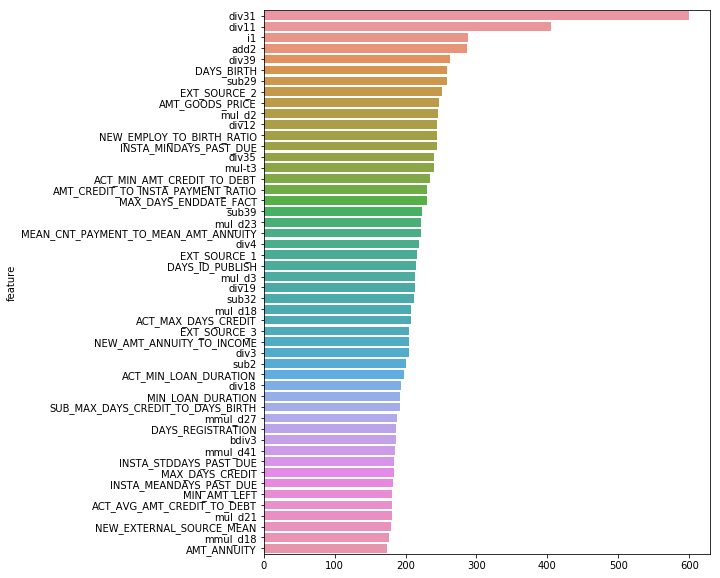

In [65]:
top_feature_importance = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50]

top_features=top_feature_importance.index

# best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(8,10))
sns.barplot(x=top_feature_importance['importance'].values,y=top_feature_importance.index)
plt.show()

In [66]:
top_feature_importance.index

Index(['div31', 'div11', 'i1', 'add2', 'div39', 'DAYS_BIRTH', 'sub29',
       'EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'mul_d2', 'div12',
       'NEW_EMPLOY_TO_BIRTH_RATIO', 'INSTA_MINDAYS_PAST_DUE', 'div35',
       'mul-t3', 'ACT_MIN_AMT_CREDIT_TO_DEBT',
       'AMT_CREDIT_TO_INSTA_PAYMENT_RATIO', 'MAX_DAYS_ENDDATE_FACT', 'sub39',
       'mul_d23', 'MEAN_CNT_PAYMENT_TO_MEAN_AMT_ANNUITY', 'div4',
       'EXT_SOURCE_1', 'DAYS_ID_PUBLISH', 'mul_d3', 'div19', 'sub32',
       'mul_d18', 'ACT_MAX_DAYS_CREDIT', 'EXT_SOURCE_3',
       'NEW_AMT_ANNUITY_TO_INCOME', 'div3', 'sub2', 'ACT_MIN_LOAN_DURATION',
       'div18', 'MIN_LOAN_DURATION', 'SUB_MAX_DAYS_CREDIT_TO_DAYS_BIRTH',
       'mmul_d27', 'DAYS_REGISTRATION', 'bdiv3', 'mmul_d41',
       'INSTA_STDDAYS_PAST_DUE', 'MAX_DAYS_CREDIT', 'INSTA_MEANDAYS_PAST_DUE',
       'MIN_AMT_LEFT', 'ACT_AVG_AMT_CREDIT_TO_DEBT', 'mul_d21',
       'NEW_EXTERNAL_SOURCE_MEAN', 'mmul_d18', 'AMT_ANNUITY'],
      dtype='object', name='feature')

In [67]:
k=feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)
print(k.loc[k['importance']!=0].shape)
k.loc[k['importance']!=0]

(611, 1)


,importance
feature,
div31,599.4
div11,405.2
i1,288.4
add2,286.6
div39,262.6
DAYS_BIRTH,258.6
sub29,258.0
EXT_SOURCE_2,251.6
AMT_GOODS_PRICE,247.0


In [68]:
less_than_one_feature_importance=k.loc[(k['importance']<1) & (k['importance']>0)].index
print(less_than_one_feature_importance)

zero_feature_importance=k.loc[k['importance']==0].index
print(zero_feature_importance[0:51])
print(zero_feature_importance[51:])

Index(['NAME_GOODS_CATEGORY_Jewelry', 'CRREDIT_COUNT_Status_Completed',
       'MAX_CREDIT_DAY_OVERDUE', 'CREDIT_MAX_RATIO_PERCENTAGE_OTHER',
       'FLAG_EMP_PHONE', 'MAX_CNT_CREDIT_PROLONG',
       'REG_REGION_NOT_LIVE_REGION', 'CREDIT_MIN_AMT_PAID_PER_INSTALLEMENT',
       'CREDIT_MAX_AMT_DRAWINGS_OTHER_CURRENT', 'ACT_AVG_CREDIT_DAY_OVERDUE',
       'CREDIT_MIN_CNT_DRAWINGS_CURRENT', 'MAX_RATE_INTEREST_PRIMARY',
       'HOUSETYPE_MODE', 'PRODUCT_COMBINATION_POS other with interest',
       'CREDIT_MEAN_RATIO_PERCENTAGE_OTHER', 'NAME_TYPE_SUITE_Other_A',
       'NAME_PAYMENT_TYPE_Non-cash from your account', 'EMERGENCYSTATE_MODE',
       'FLAG_LAST_APPL_PER_CONTRACT_N', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'CREDIT_MIN_CNT_DRAWINGS_POS_CURRENT',
       'CREDIT_MEAN_AMT_DRAWINGS_OTHER_CURRENT', 'mmul_d35',
       'MEAN_RATE_INTEREST_PRIVILEGED', 'NAME_GOODS_CATEGORY_Auto Accessories',
       'NAME_CASH_LOAN_PURPOSE_Medicine', 'MIN_RATE_INTEREST_PRIVILEGED',
       'NAME_CONTRACT_STATUS

In [71]:
sample=pd.read_csv('data/sample_submission.csv')
sample['TARGET']=preds_lgbm
sample.to_csv("for-team.csv",index=False)
sample.head(10)

,SK_ID_CURR,TARGET
0,100001,0.049809
1,100005,0.119072
2,100013,0.037666
3,100028,0.040844
4,100038,0.146452
5,100042,0.039333
6,100057,0.005823
7,100065,0.042596
8,100066,0.014873
9,100067,0.092059


## TESTING

In [70]:
# X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.1,random_state=42)
# print("Training size : (%d,%d)"%X_train.shape)
# print("Cross validation size : (%d,%d)"%X_val.shape)
# print("Target Varaible training Size: (%d,)"%y_train.shape)
# print("Target Varaible validation Size: (%d,)"%y_val.shape)


# lgbm=LGBMClassifier(n_estimators=20000,
#         learning_rate=0.005,
#         num_leaves=70,
#         colsample_bytree=.8,
#         subsample=.9,
#         max_depth=7,
#         reg_alpha=.1,
#         reg_lambda=.1,
#         min_split_gain=.01,
#         min_child_weight=2)
# lgbm.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)]
#            ,eval_metric='auc',early_stopping_rounds=150,verbose=False)

# preds_one_validation=lgbm.predict_proba(X_test)[:,1]
# print("Training AUC Score of light-gbm")
# print(roc_auc_score(y_train,lgbm.predict_proba(X_train)[:,1]))
# print("Validation AUC Score of light-gbm")
# print(roc_auc_score(y_val,lgbm.predict_proba(X_val)[:,1]))

# sample=pd.read_csv('../input/sample_submission.csv')
# sample['TARGET']=preds_one_validation
# sample.to_csv("one_validation_lgbm.csv",index=False)
# sample.head(10)

# with this i got 0.755 with one validation and 0.76 with 5 fold validation
#                 n_estimators=4000,
#                        max_depth=5,
#                         subsample=0.9
#                        ,min_child_weight=2
#                       ,reg_alpha=0.1,
#                       reg_lambda=0.1
#                        ,num_leaves=20

#  with this i got 0.762 
#     n_estimators=4000,
#             learning_rate=0.03,
#             num_leaves=30,
#             colsample_bytree=.8,
#             subsample=.9,
#             max_depth=7,
#             reg_alpha=.1,
#             reg_lambda=.1,
#             min_split_gain=.01,
#             min_child_weight=2


#         n_estimators=20000,
#         learning_rate=0.005,
#         num_leaves=70,
#         colsample_bytree=.8,
#         subsample=.9,
#         max_depth=7,
#         reg_alpha=.1,
#         reg_lambda=.1,
#         min_split_gain=.01,
#         min_child_weight=2

# import pandas as pd
# import numpy as np

# from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
# from sklearn.model_selection import KFold
# import matplotlib.pyplot as plt
# import seaborn as sns
# import gc

# gc.enable()

# buro_bal = pd.read_csv('../input/bureau_balance.csv')
# print('Buro bal shape : ', buro_bal.shape)

# print('transform to dummies')
# buro_bal = pd.concat([buro_bal, pd.get_dummies(buro_bal.STATUS, prefix='buro_bal_status')], axis=1).drop('STATUS', axis=1)

# print('Counting buros')
# buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
# buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])

# print('averaging buro bal')
# avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()

# avg_buro_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]
# del buro_bal
# gc.collect()

# print('Read Bureau')
# buro = pd.read_csv('../input/bureau.csv')

# print('Go to dummies')
# buro_credit_active_dum = pd.get_dummies(buro.CREDIT_ACTIVE, prefix='ca_')
# buro_credit_currency_dum = pd.get_dummies(buro.CREDIT_CURRENCY, prefix='cu_')
# buro_credit_type_dum = pd.get_dummies(buro.CREDIT_TYPE, prefix='ty_')

# buro_full = pd.concat([buro, buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum], axis=1)
# # buro_full.columns = ['buro_' + f_ for f_ in buro_full.columns]

# del buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum
# gc.collect()

# print('Merge with buro avg')
# buro_full = buro_full.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))

# print('Counting buro per SK_ID_CURR')
# nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
# buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])

# print('Averaging bureau')
# avg_buro = buro_full.groupby('SK_ID_CURR').mean()